In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def positional_encoding(x, num_frequencies=6, incl_input=True):


    results = []
    if incl_input:
        results.append(x)
    # encode input tensor and append the encoded tensor to the list of results.
    freq = torch.pow(2,torch.arange(num_frequencies)).to(device)
    sin_list = torch.sin(torch.pi*freq*x.reshape((-1,1))).to(device)
    cos_list  = torch.cos(torch.pi*freq*x.reshape((-1,1))).to(device)
    results.append(sin_list.reshape((x.shape[0],-1)))
    results.append(cos_list.reshape((x.shape[0],-1)))
    return torch.cat(results, dim=-1)


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


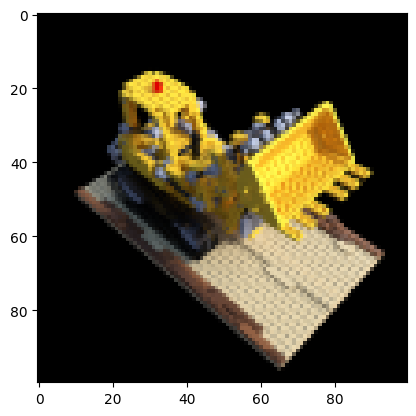

In [4]:
# Load input images, poses, and intrinsics
data = np.load("lego_data.npz")

# Images
images = data["images"]

# Height and width of each image
height, width = images.shape[1:3]

# Camera extrinsics (poses)
poses = data["poses"]
poses = torch.from_numpy(poses).to(device)

# Camera intrinsics
intrinsics = data["intrinsics"]
intrinsics = torch.from_numpy(intrinsics).to(device)

# Hold one image out (for test).
test_image, test_pose = images[101], poses[101]
test_image = torch.from_numpy(test_image).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(test_image.detach().cpu().numpy())
plt.show()

In [5]:
def get_rays(height, width, intrinsics, w_R_c, w_T_c):


    device = intrinsics.device
    ray_directions = torch.zeros((height, width, 3), device=device)  # placeholder
    ray_origins = torch.zeros((height, width, 3), device=device)  # placeholder

    coords = torch.stack(torch.meshgrid(torch.arange(height), torch.arange(width), indexing='xy'), -1).reshape((-1,2))
    coords = torch.concat((coords, torch.ones(coords.shape[0],1)), -1).to(device)
    # print(w_R_c.dtype, intrinsics.dtype, coords.dtype, w_T_c.dtype)
    rays = w_R_c @ torch.linalg.inv(intrinsics) @ coords.T
    # print(rays[:2,...])
    # print(rays.shape)
    rays = rays/torch.norm(rays, dim=0)
    rays_directions = rays.T.reshape((height,width,3))
    rays_origins = torch.broadcast_to(w_T_c.T, ((height, width,3)))
    # print(rays_directions.shape, rays_directions[0,:2,:])
    # print(rays_origins.shape, rays_origins[0,:2,:])

    return rays_origins, rays_directions

In [6]:
def stratified_sampling(ray_origins, ray_directions, near, far, samples):


    i = torch.arange(samples)
    depth = near + (i/samples)*(far-near)
    depth = depth.to(device)
    ray_points = torch.unsqueeze(ray_origins, dim=3) + torch.unsqueeze(ray_directions, dim = 3) * depth
    ray_points = ray_points.permute(0,1,3,2)
    depth_points = torch.broadcast_to(depth, (ray_origins.shape[0], ray_origins.shape[1], samples))

    return ray_points, depth_points

In [7]:
def one_forward_pass(height, width, intrinsics, pose, near, far, samples, model, num_x_frequencies, num_d_frequencies):



    #compute all the rays from the image

    pose = torch.Tensor(pose)
    # print(poses.dtype)
    w_R_c = pose[:3,:3]
    w_T_c = pose[:3,3]
    ray_o, ray_d = get_rays(height, width, intrinsics, w_R_c.reshape((3,3)), w_T_c.reshape((3,1)))

    #sample the points from the rays
    ray_points, depth_points = stratified_sampling(ray_o, ray_d, near, far, samples)

    #divide data into batches to avoid memory errors
    ray_points_batches, ray_directions_batches = get_batches(ray_points, ray_d, num_x_frequencies, num_d_frequencies)
    rgb_list = []
    sigma_list =[]
    #forward pass the batches and concatenate the outputs at the end
    for batch_i in range(len(ray_points_batches)):
      #forward pass the batches and concatenate the outputs at the end
      rgb, sigma = model(ray_points_batches[batch_i], ray_directions_batches[batch_i])
      rgb_list.append(rgb)
      sigma_list.append(sigma)
      # Apply volumetric rendering to obtain the reconstructed image
    rec_image = volumetric_rendering(torch.concat(rgb_list, 0).reshape((height, width,samples, 3)), torch.concat(sigma_list,0).reshape((height, width, samples)), depth_points)


    return rec_image

In [8]:
def get_batches(ray_points, ray_directions, num_x_frequencies, num_d_frequencies):

    def get_chunks(inputs, chunksize = 2**15):
        
        return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

   

    ray_directions = torch.unsqueeze(ray_directions, dim=2)
    ray_directions = torch.broadcast_to(ray_directions, ray_points.shape)
    # print('ray_direction shape:', ray_directions.shape)
    # print('ray points shape:', ray_points.shape)
    # embed_ray_dir = positional_encoding(ray_directions.reshape((-1,3)), num_frequencies=num_d_frequencies, incl_input=True)
    # embed_ray_point = positional_encoding(ray_points.reshape((-1,3)), num_frequencies=num_x_frequencies, incl_input=True)
    ray_points_batches = get_chunks(ray_points.reshape((-1,3)))
    ray_directions_batches = get_chunks(ray_directions.reshape((-1,3)))
    # ray_points_batches = torch.concat(ray_points_batches, 0)
    # ray_directions_batches = torch.concat(ray_directions_batches, 0)
    # print('ray_direction batches shape:', ray_directions_batches.shape)
    # print('ray points batches shape:', ray_points_batches.shape)


    return ray_points_batches, ray_directions_batches

In [9]:
def volumetric_rendering(rgb, s, depth_points):


    delta = depth_points[...,1:]  - depth_points[...,:-1]
    delta = torch.concat([delta, torch.ones((delta.shape[0], delta.shape[1], 1)).to(device)*1e9], -1) #
    inter_Ti = torch.exp(-s*delta)
    Ti = torch.concat([torch.ones((delta.shape[0], delta.shape[1], 1)).to(device),torch.cumprod(inter_Ti, dim=-1)[:,:,:-1]], -1)

    c = torch.unsqueeze(Ti, dim=-1) * (1-torch.unsqueeze(inter_Ti, dim=-1)) * rgb
    rec_image = torch.sum(c, dim=2)


    return rec_image

In [10]:
class nerf_model(nn.Module):


    def __init__(self, filter_size=256, num_x_frequencies=6, num_d_frequencies=3):
        super().__init__()

  
        self.layers = nn.ModuleDict({
            'layer_1': nn.Linear(3 , filter_size),
            'layer_2': nn.Linear(filter_size,filter_size),
            'layer_3': nn.Linear(filter_size,filter_size),
            'layer_4': nn.Linear(filter_size,filter_size),
            'layer_5': nn.Linear(filter_size,filter_size),
            'layer_6': nn.Linear(filter_size+3 , filter_size),
            'layer_7': nn.Linear(filter_size,filter_size),
            'layer_8': nn.Linear(filter_size,filter_size),
            'layer_s': nn.Linear(filter_size,1),
            'layer_9': nn.Linear(filter_size,filter_size),
            'layer_10': nn.Linear(filter_size+3 ,filter_size//2),
            'layer_11': nn.Linear(filter_size//2, 3),
        })




    def forward(self, x, d):

        out = self.layers['layer_1'](x)
        out = F.relu(out)
        out = self.layers['layer_2'](out)
        out = F.relu(out)
        out = self.layers['layer_3'](out)
        out = F.relu(out)
        out = self.layers['layer_4'](out)
        out = F.relu(out)
        out = self.layers['layer_5'](out)
        out = F.relu(out)
        out = torch.concat([x,out], -1)
        out = self.layers['layer_6'](out)
        out = F.relu(out)
        out = self.layers['layer_7'](out)
        out = F.relu(out)
        out = self.layers['layer_8'](out)
        sigma = self.layers['layer_s'](out)
        sigma = F.relu(sigma)
        out = self.layers['layer_9'](out)
        out = F.relu(out)
        out = torch.concat([out, d], -1)
        out = self.layers['layer_10'](out)
        out = F.relu(out)
        out = self.layers['layer_11'](out)
        rgb = F.sigmoid(out)

        return rgb, sigma

In [11]:
def one_forward_pass(height, width, intrinsics, w_R_c, w_T_c, near, far, samples, model, num_x_frequencies, num_d_frequencies):



    #compute all the rays from the image

    # pose = torch.Tensor(pose)
    # # print(poses.dtype)
    # w_R_c = pose[:3,:3]
    # w_T_c = pose[:3,3]
    ray_o, ray_d = get_rays(height, width, intrinsics, w_R_c.reshape((3,3)), w_T_c.reshape((3,1)))

    #sample the points from the rays
    ray_points, depth_points = stratified_sampling(ray_o, ray_d, near, far, samples)

    #divide data into batches to avoid memory errors
    ray_points_batches, ray_directions_batches = get_batches(ray_points, ray_d, num_x_frequencies, num_d_frequencies)
    rgb_list = []
    sigma_list =[]
    #forward pass the batches and concatenate the outputs at the end
    for batch_i in range(len(ray_points_batches)):
      #forward pass the batches and concatenate the outputs at the end
      rgb, sigma = model(ray_points_batches[batch_i], ray_directions_batches[batch_i])
      rgb_list.append(rgb)
      sigma_list.append(sigma)
      # Apply volumetric rendering to obtain the reconstructed image
    rec_image = volumetric_rendering(torch.concat(rgb_list, 0).reshape((height, width,samples, 3)), torch.concat(sigma_list,0).reshape((height, width, samples)), depth_points)


    return rec_image

In [12]:
num_x_frequencies = 10
num_d_frequencies = 4
learning_rate  = 5e-4
iterations = 3000
samples = 64
display = 25
near = 0.667
far = 2

model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnrs = []
iternums = []

t = time.time()
t0 = time.time()

In [13]:
criterion = torch.nn.MSELoss()

In [14]:
model = nerf_model(num_x_frequencies=num_x_frequencies,num_d_frequencies=num_d_frequencies).to(device)
model.load_state_dict(torch.load('model_nerf-wo_PE.pt'))

<All keys matched successfully>

### Rotation only

In [15]:
from scipy.spatial.transform import Rotation

In [15]:
### rotation
### test image
test_pose_w_R_c = test_pose[:3,:3]
test_pose_w_T_c = test_pose[:3, 3]
angle_noise = 0.1 # radians
r =  Rotation.from_euler('xyz', np.random.randn(3)*angle_noise, degrees=False)
rot_d = torch.from_numpy(r.as_matrix()).float().to(device)
test_pose_w_R_c_perturb = rot_d @ test_pose_w_R_c
test_pose_w_R_c, test_pose_w_R_c_perturb.shape,test_pose_w_R_c_perturb

(tensor([[ 6.8935e-01, -5.3373e-01,  4.8982e-01],
         [-7.2443e-01, -5.0789e-01,  4.6611e-01],
         [ 1.4901e-08, -6.7615e-01, -7.3676e-01]], device='cuda:0'),
 torch.Size([3, 3]),
 tensor([[ 0.8048, -0.4862,  0.3404],
         [-0.5891, -0.5846,  0.5578],
         [-0.0723, -0.6495, -0.7569]], device='cuda:0'))

In [19]:
import copy

In [17]:
lr_rotation = 0.01

Test image MSE is: 0.00845222920179367
Iteration 0  Loss: 0.1186  PSNR: 9.26  Time: 0.33 secs per iter,  0.14 mins in total


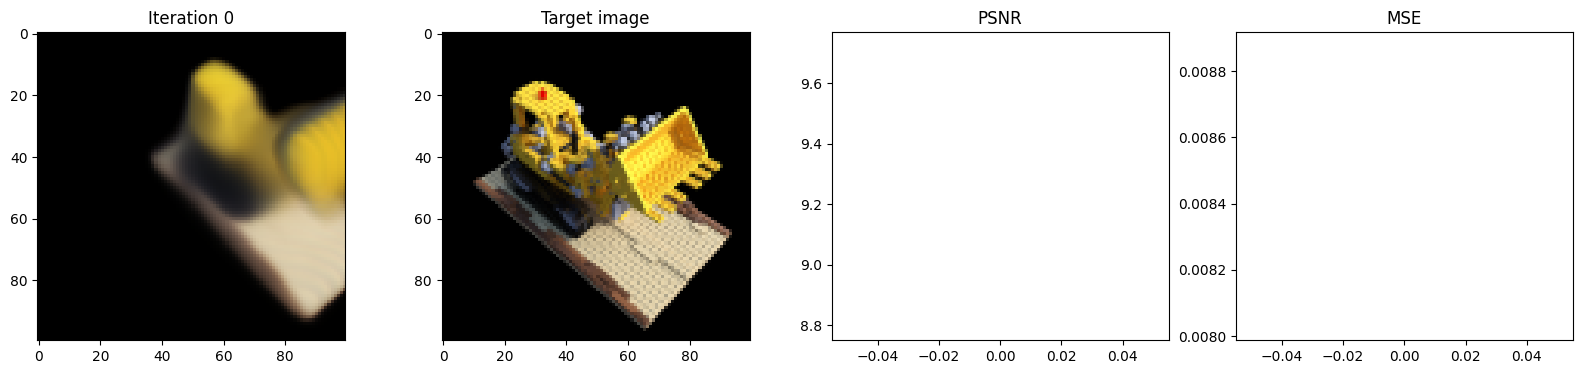

Test image MSE is: 0.005765367299318314
Iteration 25  Loss: 0.0636  PSNR: 11.96  Time: 0.28 secs per iter,  0.25 mins in total


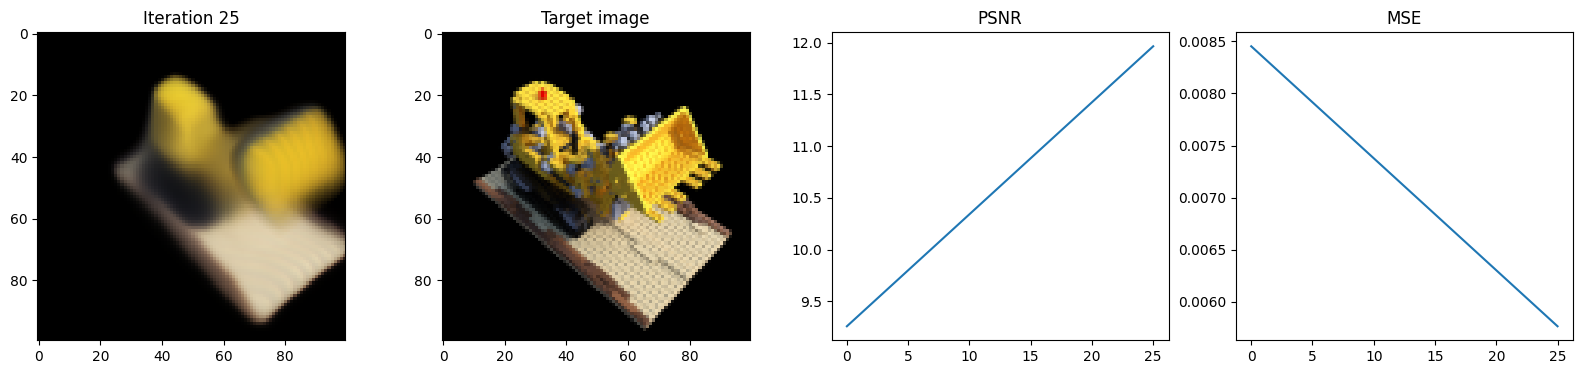

Test image MSE is: 0.004710400477051735
Iteration 50  Loss: 0.0167  PSNR: 17.78  Time: 0.28 secs per iter,  0.37 mins in total


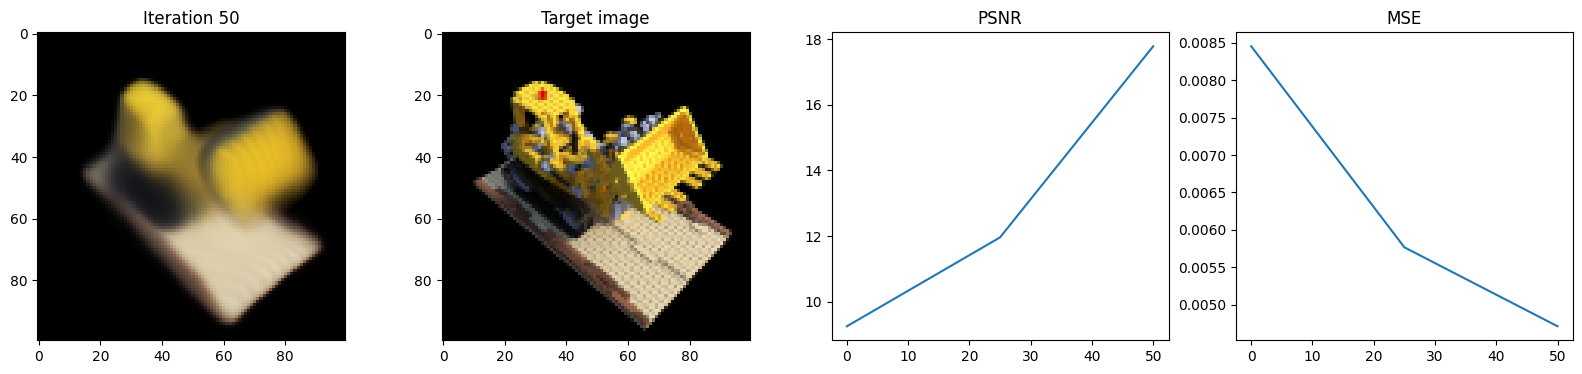

Test image MSE is: 0.0041825296357274055
Iteration 75  Loss: 0.0144  PSNR: 18.42  Time: 0.28 secs per iter,  0.49 mins in total


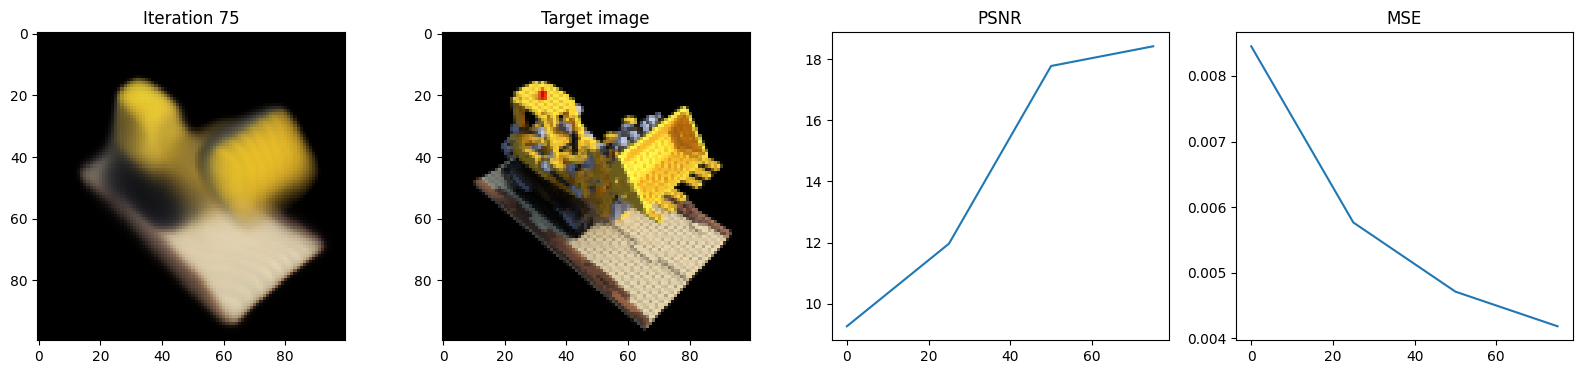

Test image MSE is: 0.003801196813583374
Iteration 100  Loss: 0.0130  PSNR: 18.85  Time: 0.28 secs per iter,  0.60 mins in total


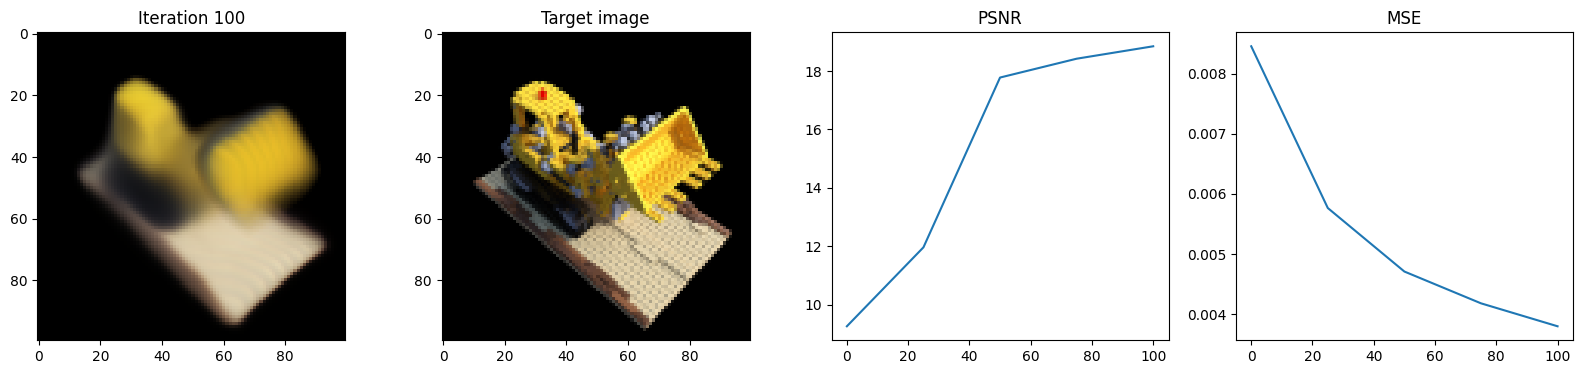

Test image MSE is: 0.0035116421058773994
Iteration 125  Loss: 0.0122  PSNR: 19.13  Time: 0.28 secs per iter,  0.72 mins in total


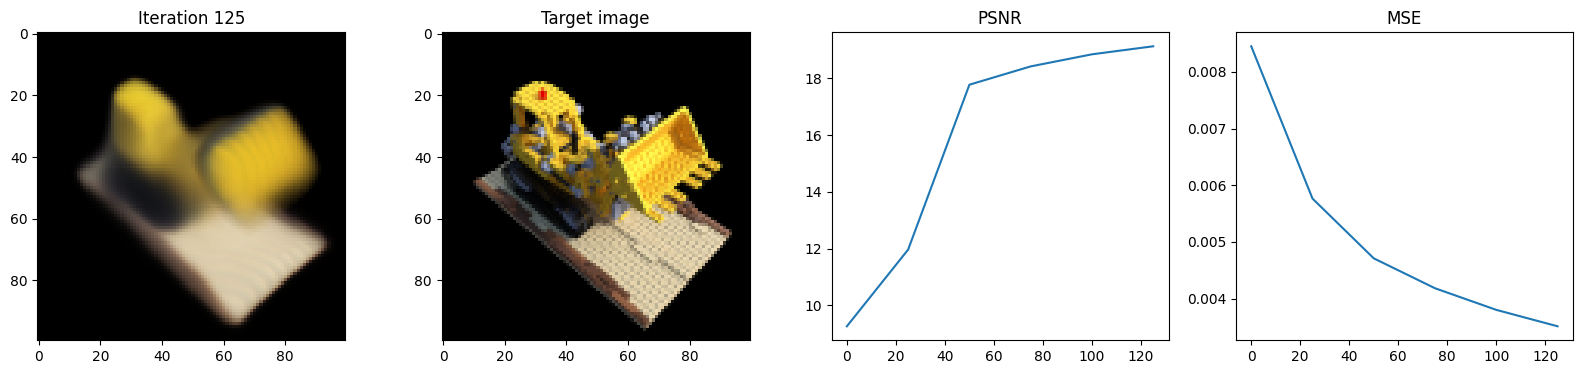

Test image MSE is: 0.0032793376594781876
Iteration 150  Loss: 0.0117  PSNR: 19.33  Time: 0.28 secs per iter,  0.83 mins in total


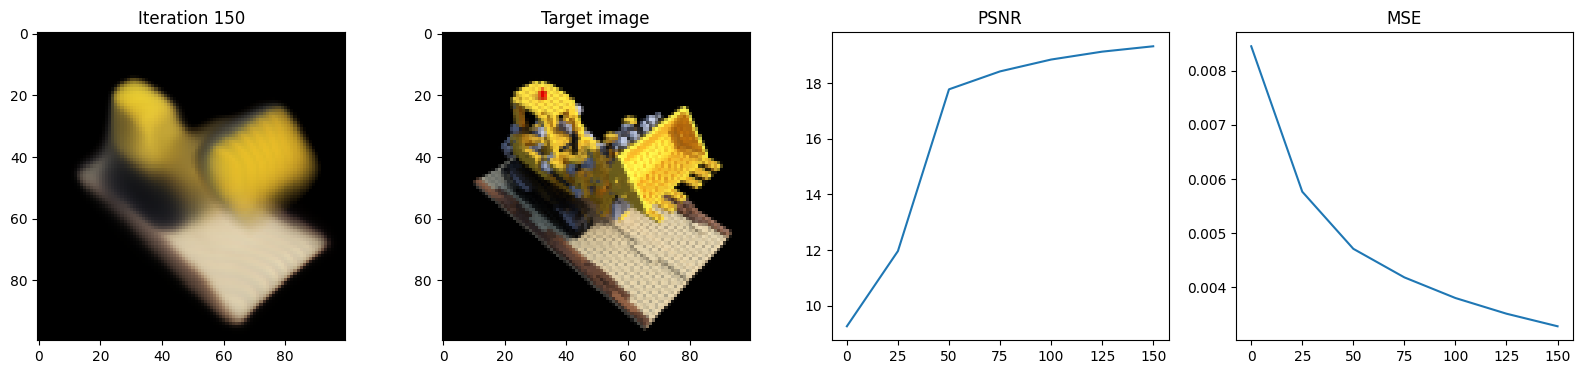

Test image MSE is: 0.0030839908868074417
Iteration 175  Loss: 0.0113  PSNR: 19.46  Time: 0.28 secs per iter,  0.95 mins in total


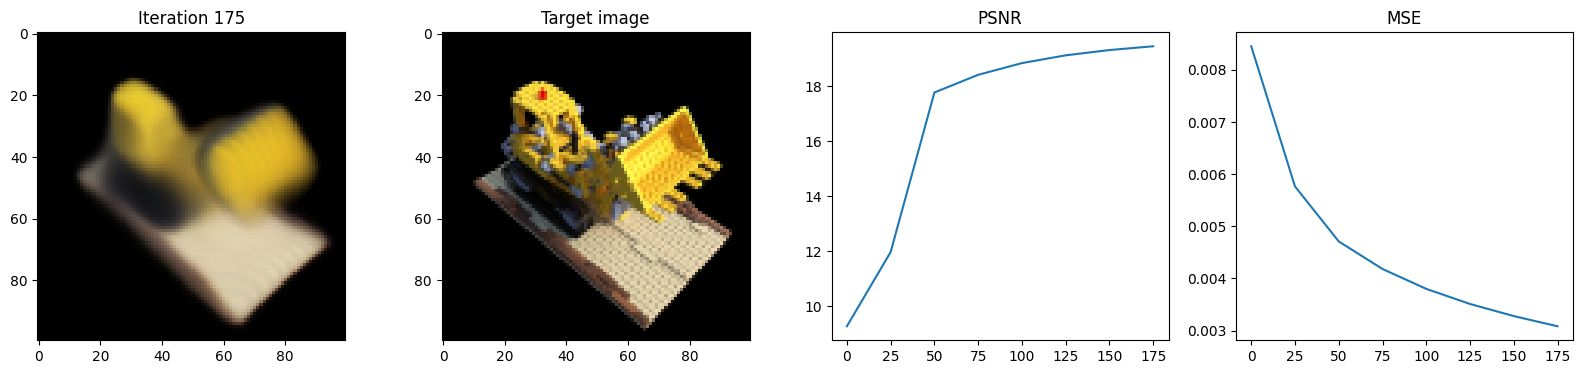

Test image MSE is: 0.002915157238021493
Iteration 200  Loss: 0.0111  PSNR: 19.56  Time: 0.28 secs per iter,  1.07 mins in total


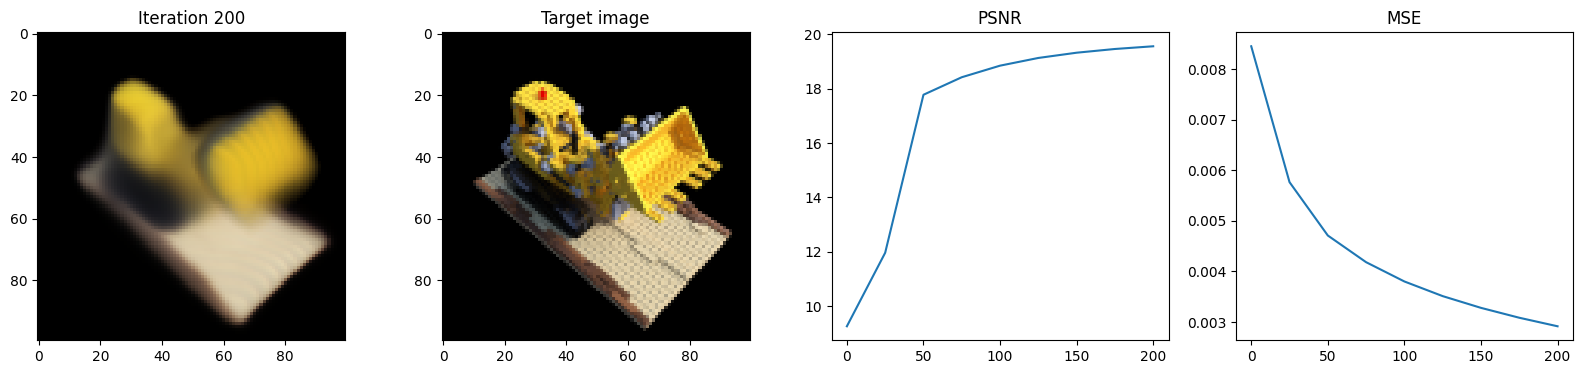

Test image MSE is: 0.0027657642494887114
Iteration 225  Loss: 0.0109  PSNR: 19.64  Time: 0.28 secs per iter,  1.18 mins in total


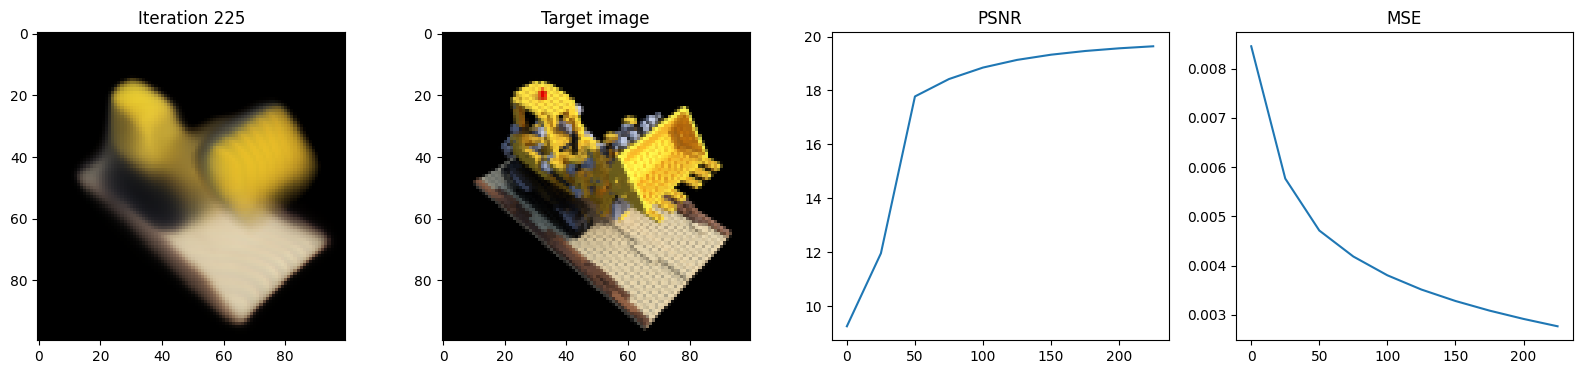

Test image MSE is: 0.002631538547575474
Iteration 250  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  1.30 mins in total


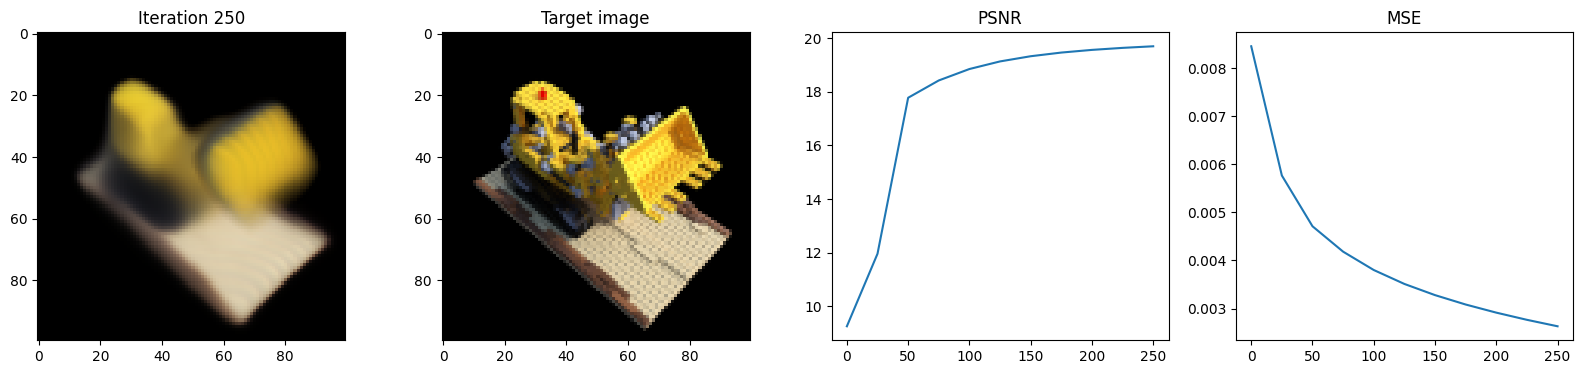

Test image MSE is: 0.002630251459777355
Iteration 275  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  1.42 mins in total


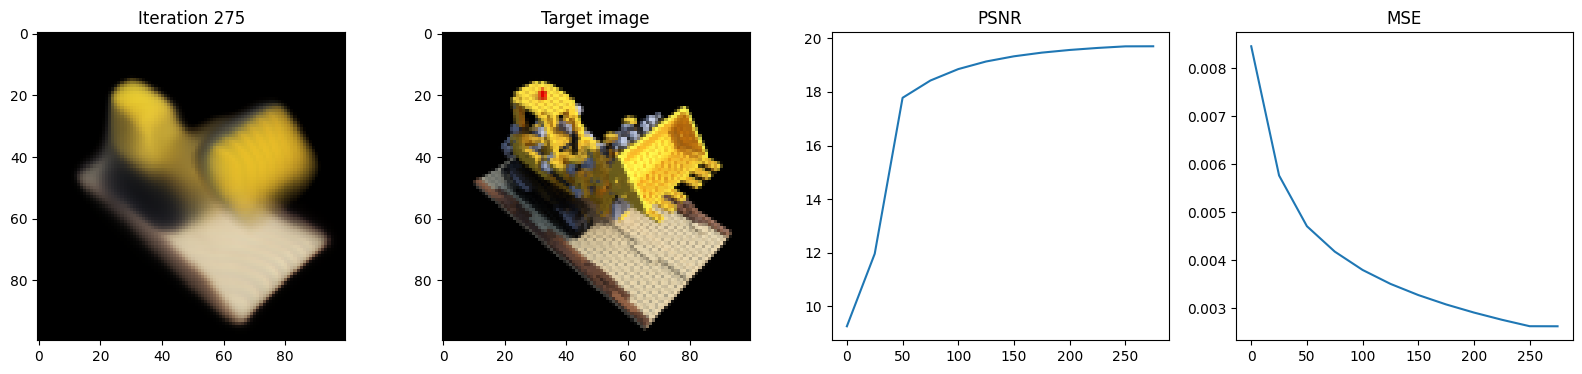

Test image MSE is: 0.002628966001793742
Iteration 300  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  1.53 mins in total


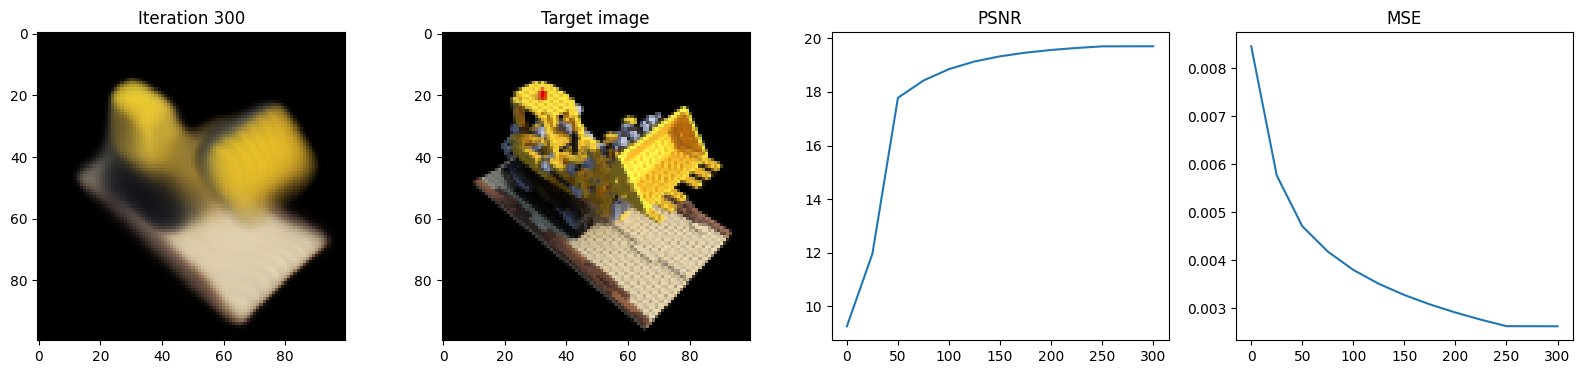

Test image MSE is: 0.002627682639285922
Iteration 325  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  1.65 mins in total


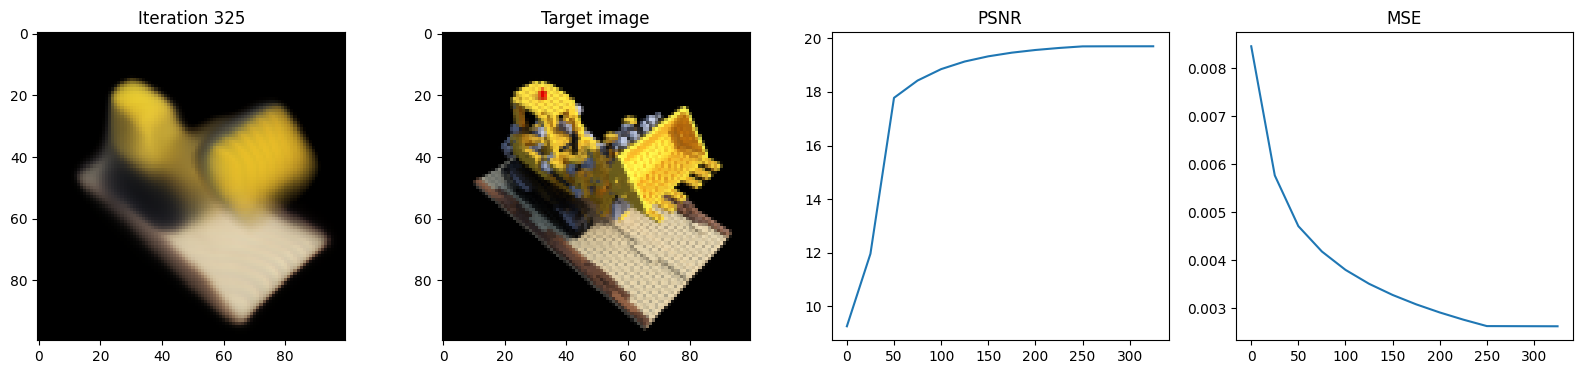

Test image MSE is: 0.002626406727358699
Iteration 350  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  1.76 mins in total


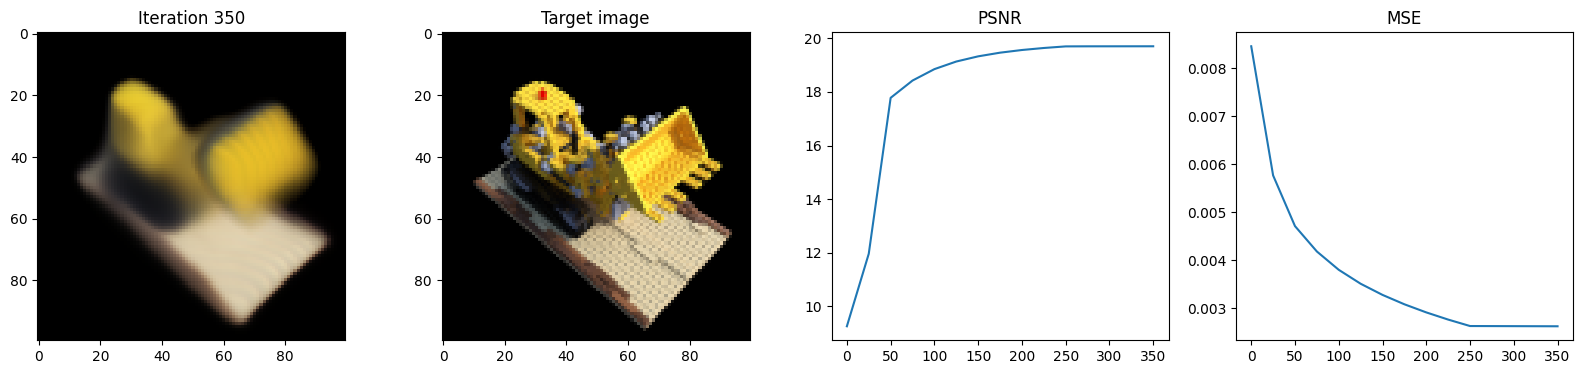

Test image MSE is: 0.0026251249946653843
Iteration 375  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  1.88 mins in total


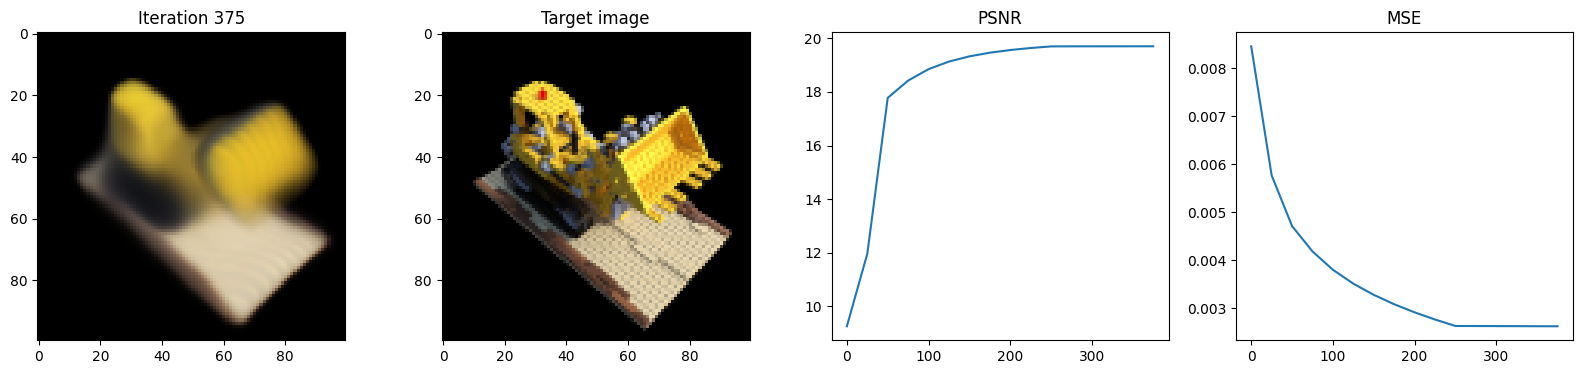

Test image MSE is: 0.0026238420978188515
Iteration 400  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  2.00 mins in total


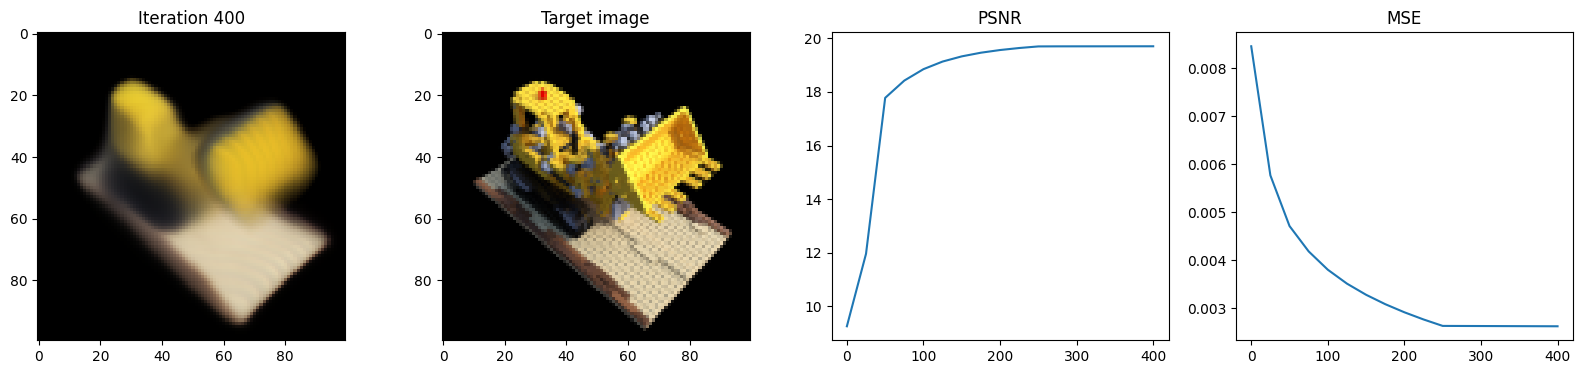

Test image MSE is: 0.002622561063617468
Iteration 425  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  2.11 mins in total


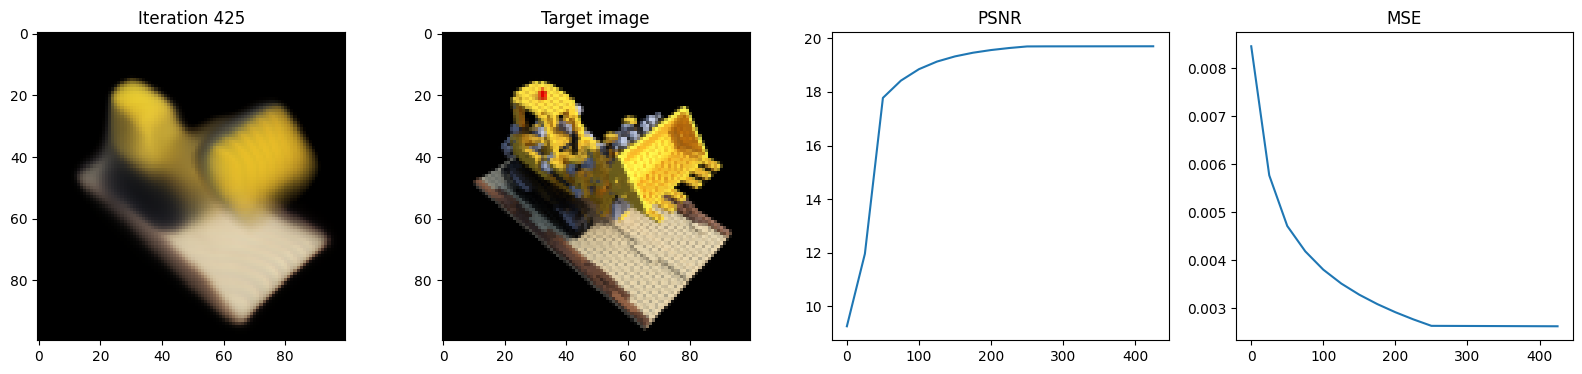

Test image MSE is: 0.0026212807279080153
Iteration 450  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  2.23 mins in total


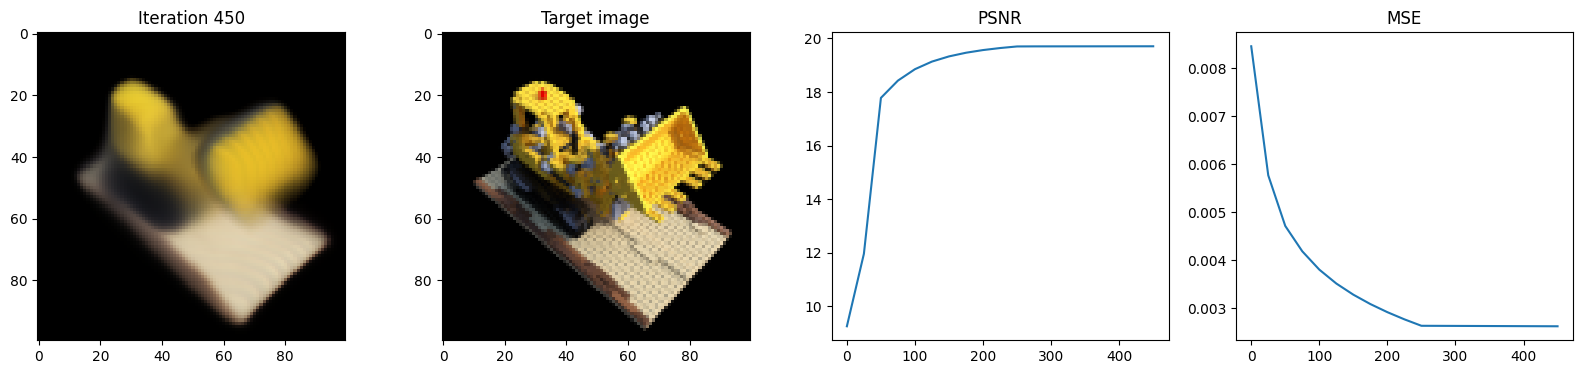

Test image MSE is: 0.0026199952699244022
Iteration 475  Loss: 0.0107  PSNR: 19.70  Time: 0.28 secs per iter,  2.34 mins in total


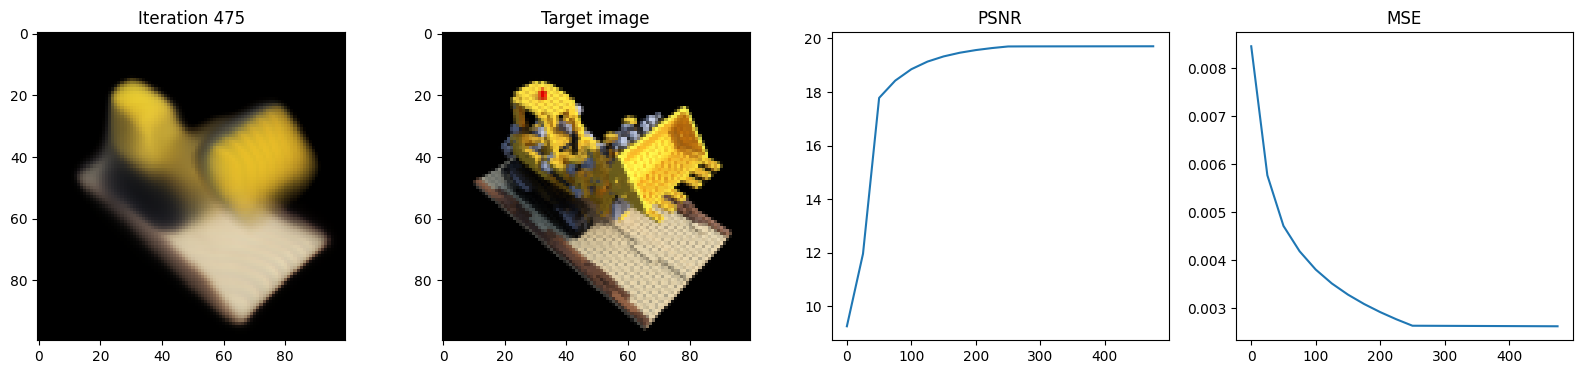

In [18]:
### iterating to see how the error reduces on rotation
mse_list = []
iternums = []
psnrs = []
for i in range(500):
    test_input = copy.deepcopy(test_pose_w_R_c_perturb)
    test_input.requires_grad_()
    # Run one iteration of NeRF and get the rendered RGB image.

    rec_image = one_forward_pass(height, width, intrinsics, test_input.to(device), test_pose_w_T_c.to(device), near, far, samples, model, num_x_frequencies, num_d_frequencies)
    loss = criterion(rec_image, test_image)
    optimizer.zero_grad()
    loss.backward()
    test_pose_w_R_c_perturb = test_pose_w_R_c_perturb - lr_rotation * test_input.grad.detach()
     
    mse = criterion(test_pose_w_R_c_perturb.to('cpu'),test_pose_w_R_c.to('cpu')).detach().item()
    if i%25==0:
        print('Test image MSE is:', mse)
        mse_list.append(mse)

        psnr = 10 * torch.log10((torch.max(test_image)**2)/loss.item())



        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
                "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))
    
        t = time.time()
        psnrs.append(psnr.item())
        iternums.append(i)
    
        plt.figure(figsize=(20, 4))
        plt.subplot(141)
        plt.imshow(rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.subplot(144)
        plt.plot(iternums, mse_list)
        plt.title("MSE")
        plt.show()
    if i%250==0 and i>0 and i<601:
            lr_rotation *= 0.01

    

In [16]:
### rotation
### test image
test_pose_w_R_c = test_pose[:3, :3]
test_pose_w_T_c = test_pose[:3,3]
angle_noise = 0.2 # radians
r =  Rotation.from_euler('xyz', np.random.randn(3)*angle_noise, degrees=False)
rot_d = torch.from_numpy(r.as_matrix()).float().to(device)
test_pose_w_R_c_perturb = rot_d @ test_pose_w_R_c
test_pose_w_R_c, test_pose_w_R_c_perturb.shape,test_pose_w_R_c_perturb

(tensor([[ 6.8935e-01, -5.3373e-01,  4.8982e-01],
         [-7.2443e-01, -5.0789e-01,  4.6611e-01],
         [ 1.4901e-08, -6.7615e-01, -7.3676e-01]], device='cuda:0'),
 torch.Size([3, 3]),
 tensor([[ 0.5396, -0.7424,  0.3970],
         [-0.8315, -0.3960,  0.3897],
         [-0.1321, -0.5404, -0.8310]], device='cuda:0'))

In [17]:
lr_rotation = 0.01

Test image MSE is: 0.01644914411008358
Iteration 0  Loss: 0.1156  PSNR: 9.37  Time: 1.10 secs per iter,  0.46 mins in total


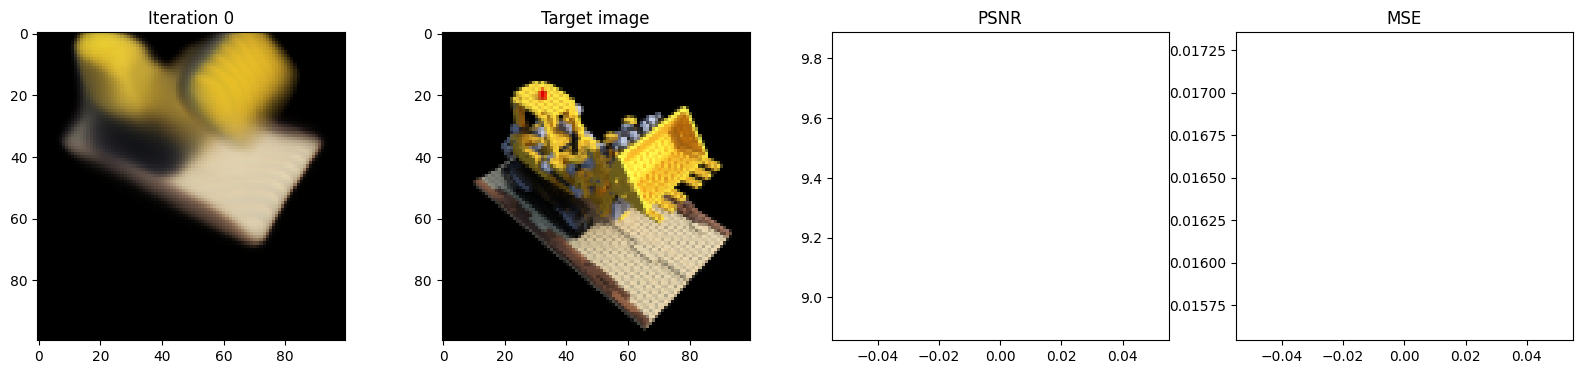

Test image MSE is: 0.013378000818192959
Iteration 25  Loss: 0.0472  PSNR: 13.26  Time: 0.28 secs per iter,  0.57 mins in total


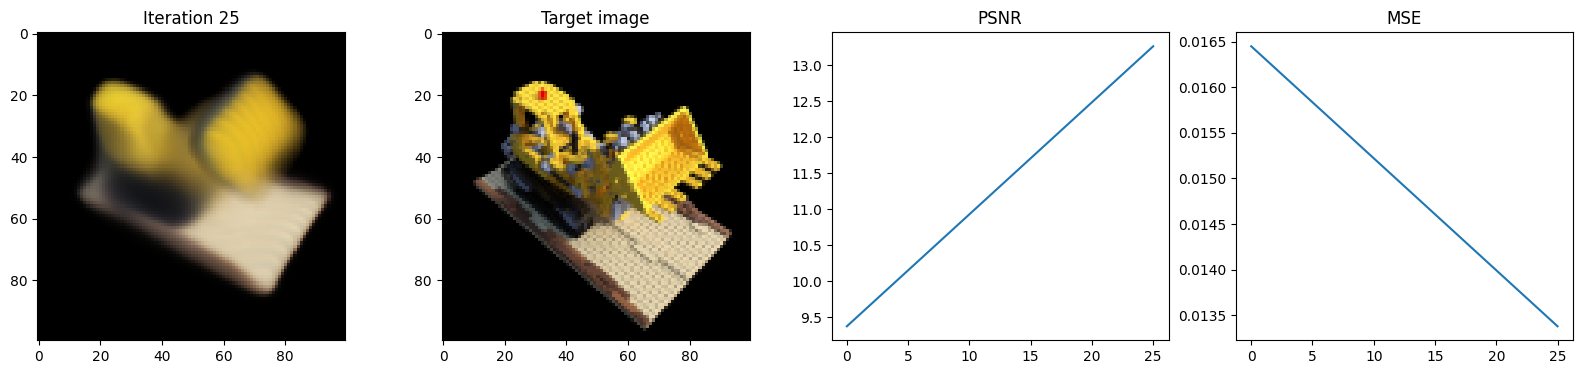

Test image MSE is: 0.011636032722890377
Iteration 50  Loss: 0.0294  PSNR: 15.32  Time: 0.28 secs per iter,  0.69 mins in total


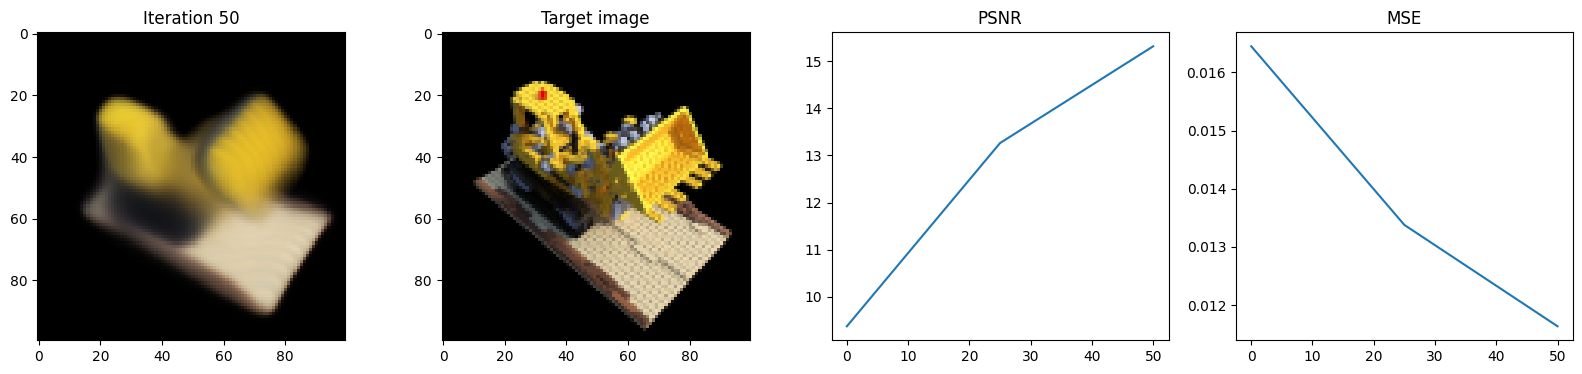

Test image MSE is: 0.010237263515591621
Iteration 75  Loss: 0.0264  PSNR: 15.78  Time: 0.28 secs per iter,  0.81 mins in total


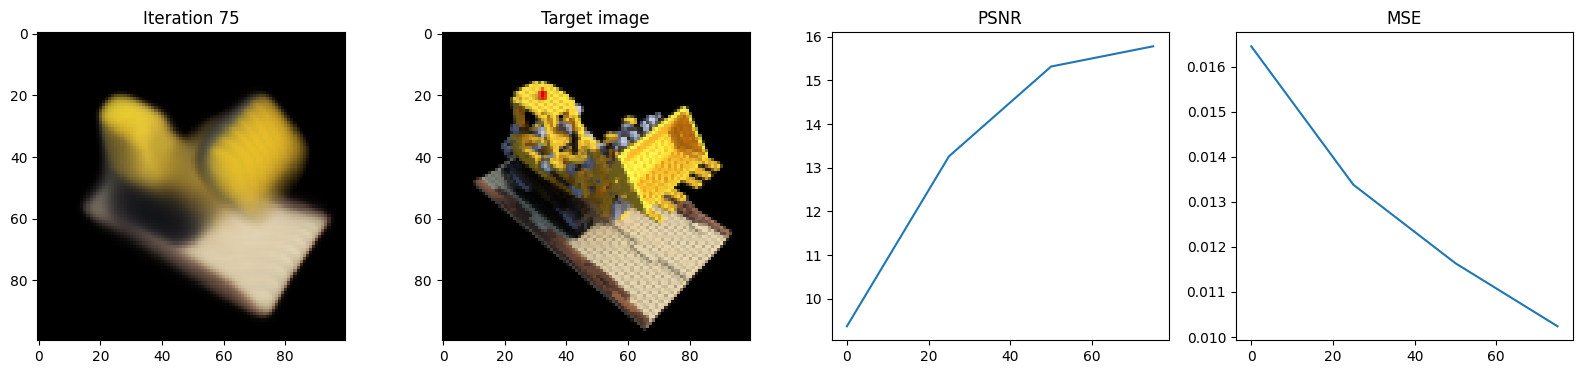

Test image MSE is: 0.008986648172140121
Iteration 100  Loss: 0.0235  PSNR: 16.30  Time: 0.28 secs per iter,  0.92 mins in total


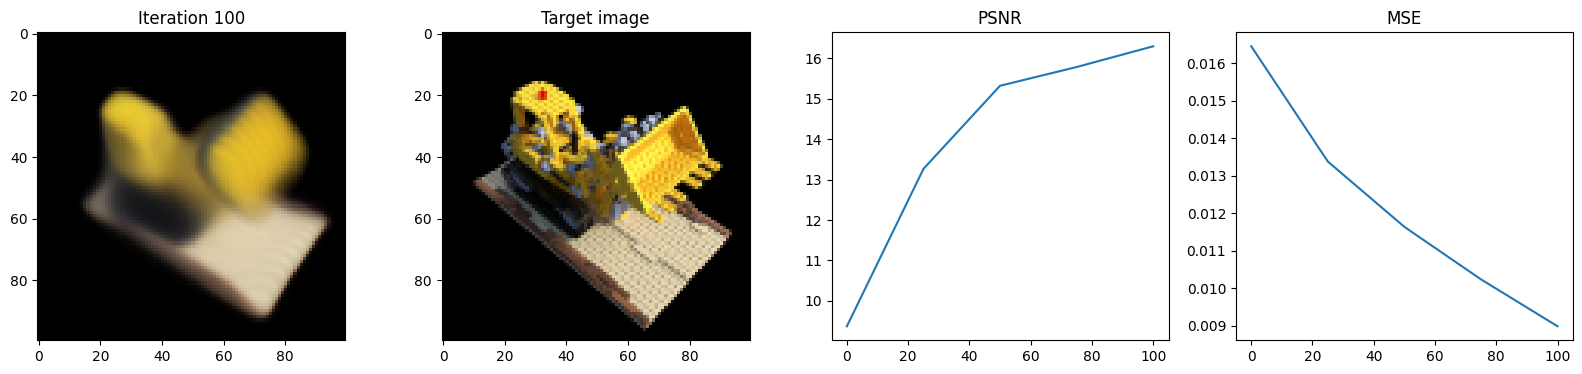

Test image MSE is: 0.007902082055807114
Iteration 125  Loss: 0.0206  PSNR: 16.85  Time: 0.28 secs per iter,  1.04 mins in total


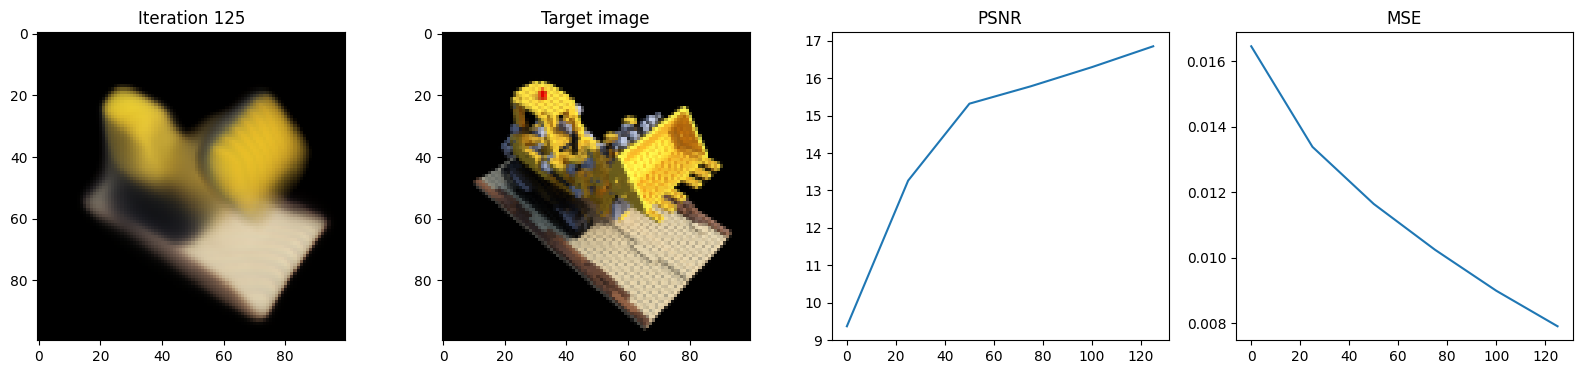

Test image MSE is: 0.006996308919042349
Iteration 150  Loss: 0.0181  PSNR: 17.42  Time: 0.28 secs per iter,  1.16 mins in total


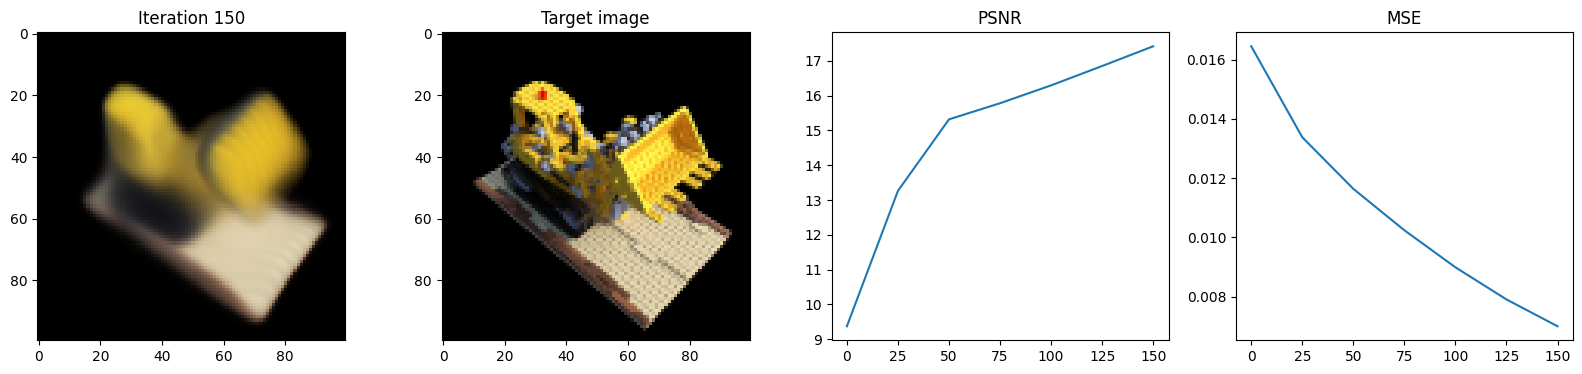

Test image MSE is: 0.006263029295951128
Iteration 175  Loss: 0.0161  PSNR: 17.94  Time: 0.28 secs per iter,  1.27 mins in total


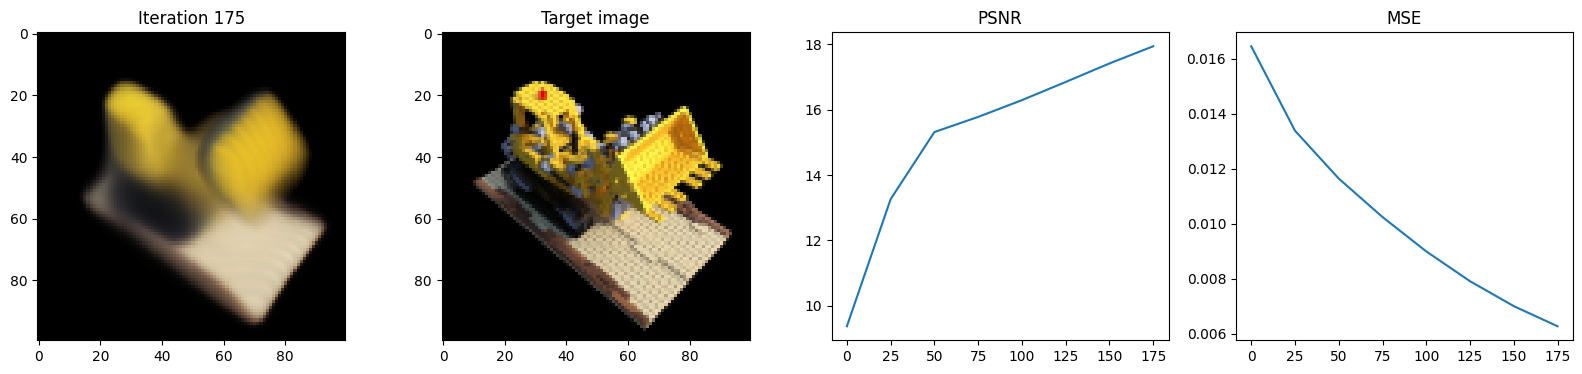

Test image MSE is: 0.0056796870194375515
Iteration 200  Loss: 0.0145  PSNR: 18.38  Time: 0.28 secs per iter,  1.39 mins in total


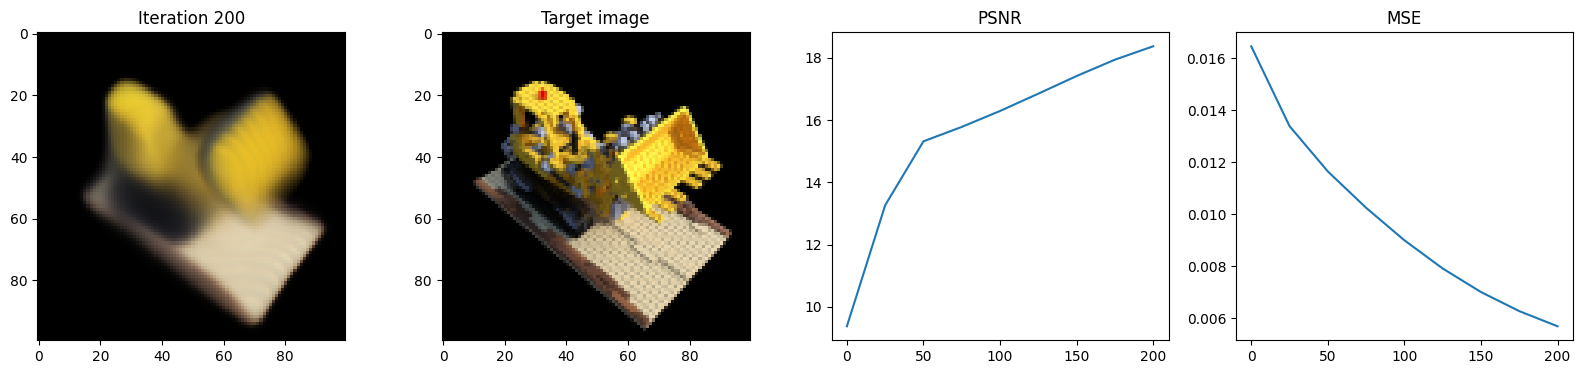

Test image MSE is: 0.005209163296967745
Iteration 225  Loss: 0.0135  PSNR: 18.71  Time: 0.28 secs per iter,  1.51 mins in total


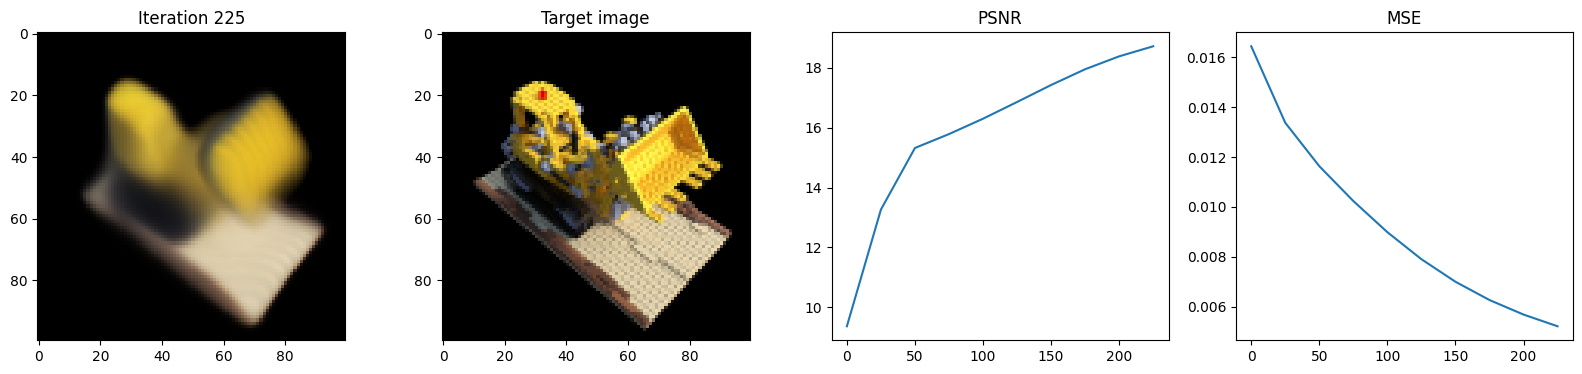

Test image MSE is: 0.004820261616259813
Iteration 250  Loss: 0.0127  PSNR: 18.97  Time: 0.28 secs per iter,  1.62 mins in total


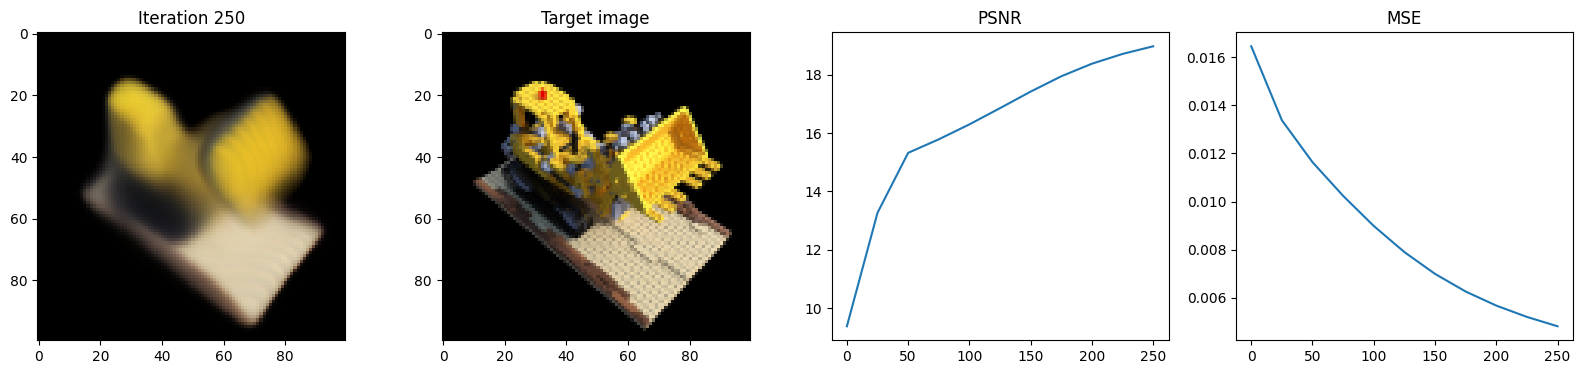

Test image MSE is: 0.00481672678142786
Iteration 275  Loss: 0.0126  PSNR: 18.98  Time: 0.28 secs per iter,  1.74 mins in total


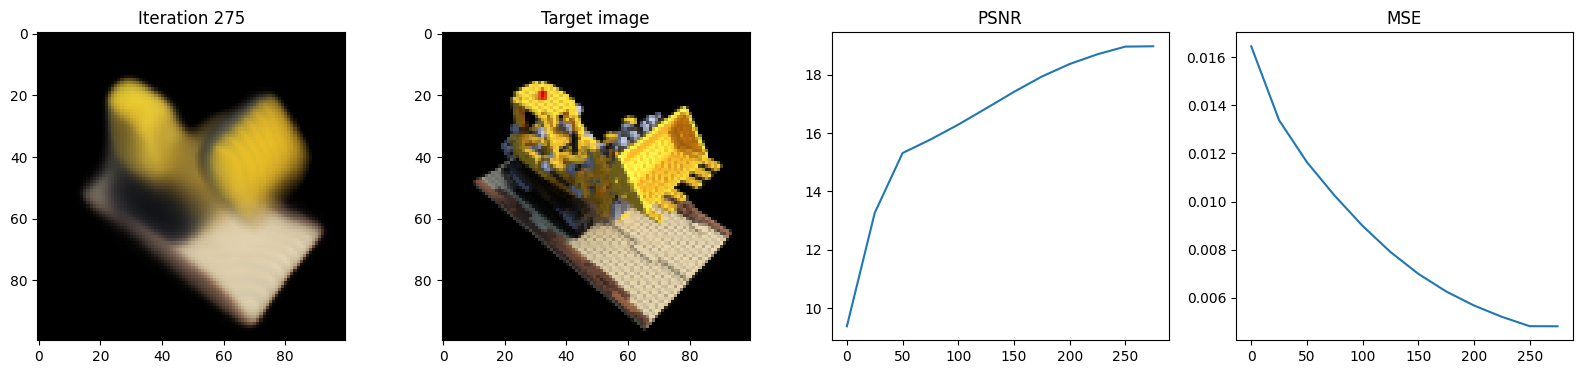

Test image MSE is: 0.00481319660320878
Iteration 300  Loss: 0.0126  PSNR: 18.99  Time: 0.28 secs per iter,  1.85 mins in total


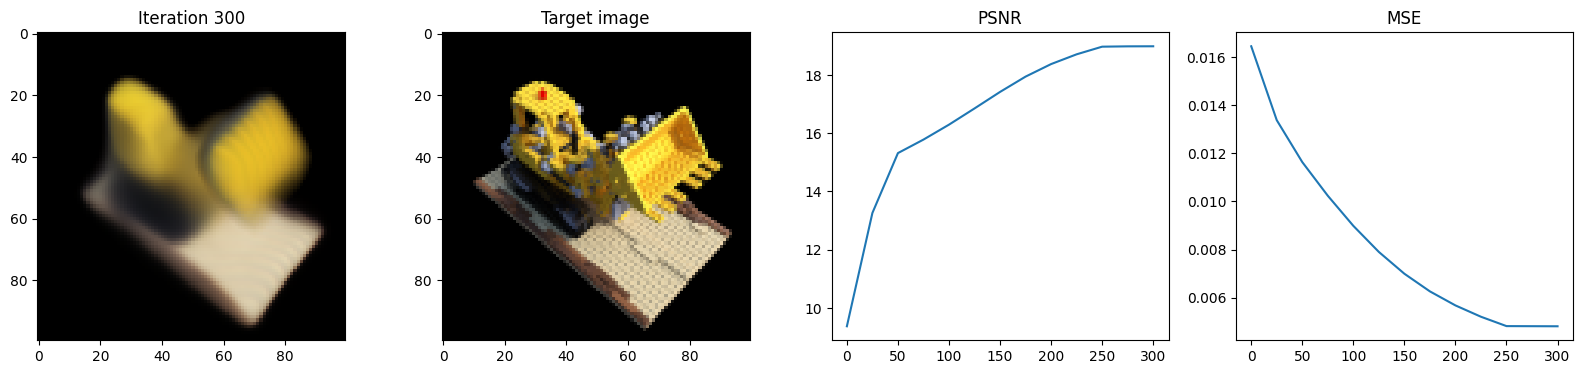

Test image MSE is: 0.004809671081602573
Iteration 325  Loss: 0.0126  PSNR: 18.99  Time: 0.28 secs per iter,  1.97 mins in total


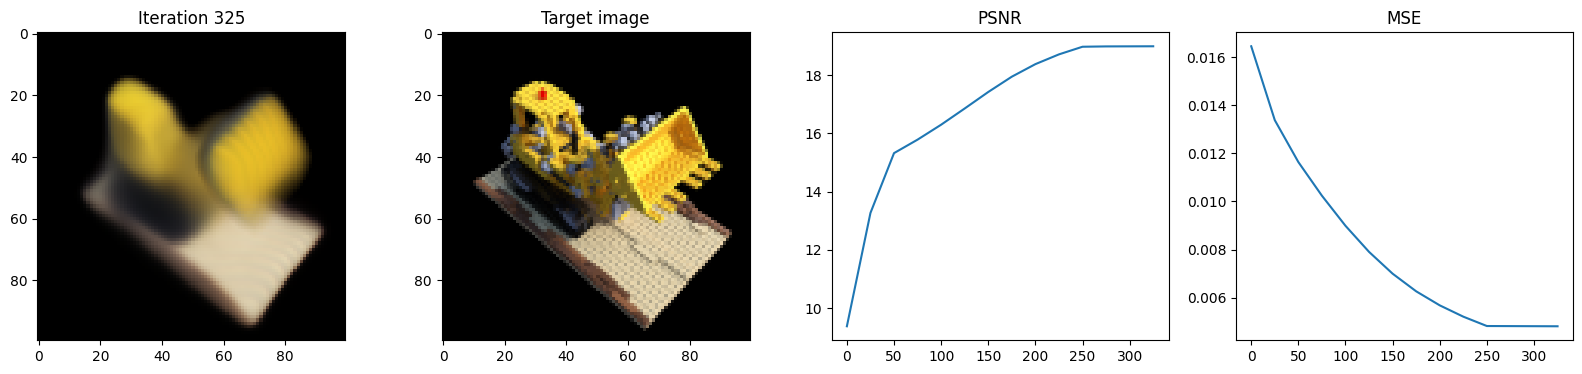

Test image MSE is: 0.00480614835396409
Iteration 350  Loss: 0.0126  PSNR: 18.99  Time: 0.28 secs per iter,  2.09 mins in total


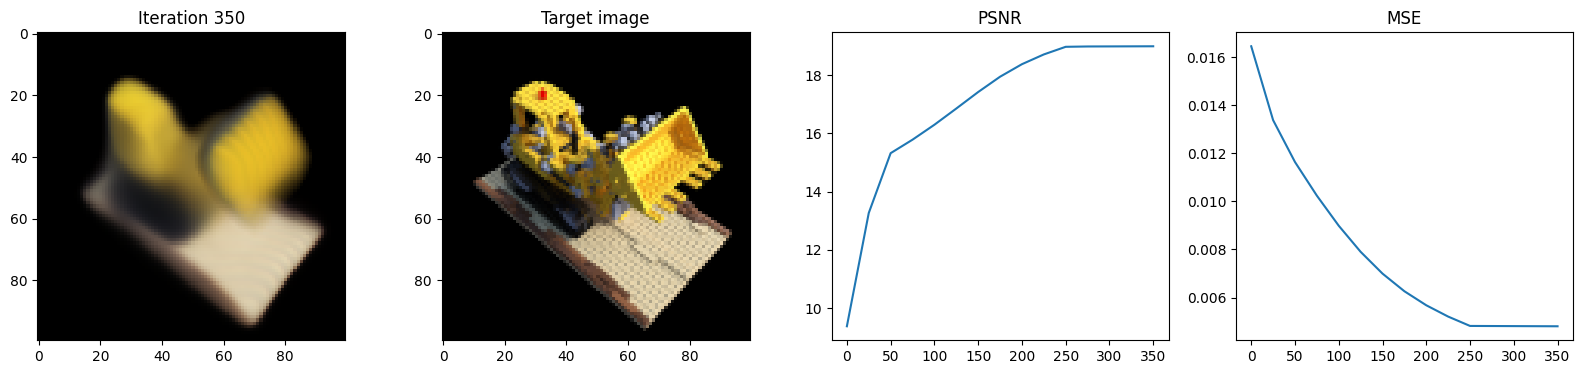

Test image MSE is: 0.00480263028293848
Iteration 375  Loss: 0.0126  PSNR: 18.99  Time: 0.28 secs per iter,  2.20 mins in total


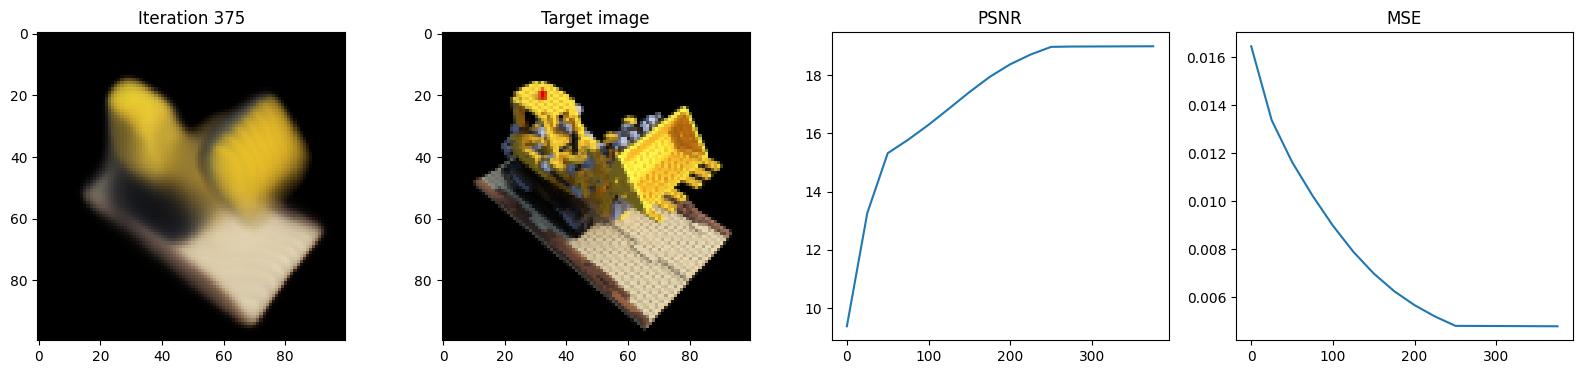

Test image MSE is: 0.004799115005880594
Iteration 400  Loss: 0.0126  PSNR: 19.00  Time: 0.28 secs per iter,  2.32 mins in total


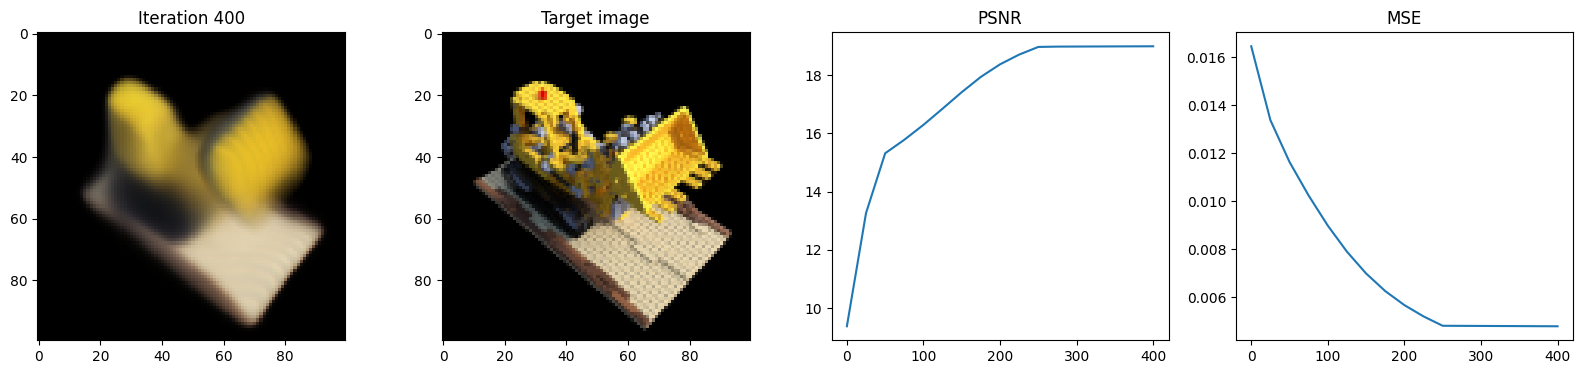

Test image MSE is: 0.004795601591467857
Iteration 425  Loss: 0.0126  PSNR: 19.00  Time: 0.28 secs per iter,  2.44 mins in total


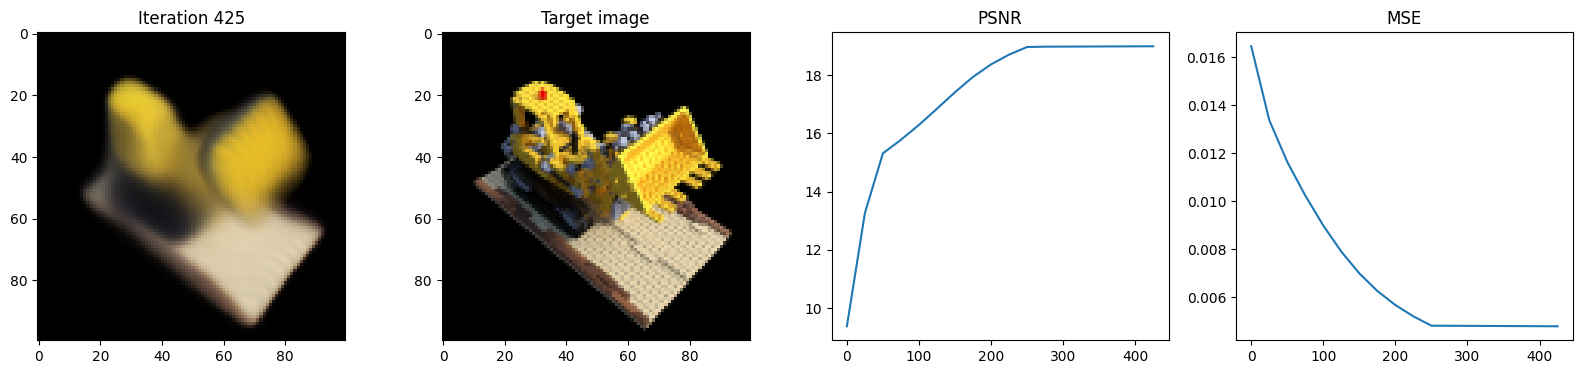

Test image MSE is: 0.004792102612555027
Iteration 450  Loss: 0.0126  PSNR: 19.00  Time: 0.28 secs per iter,  2.55 mins in total


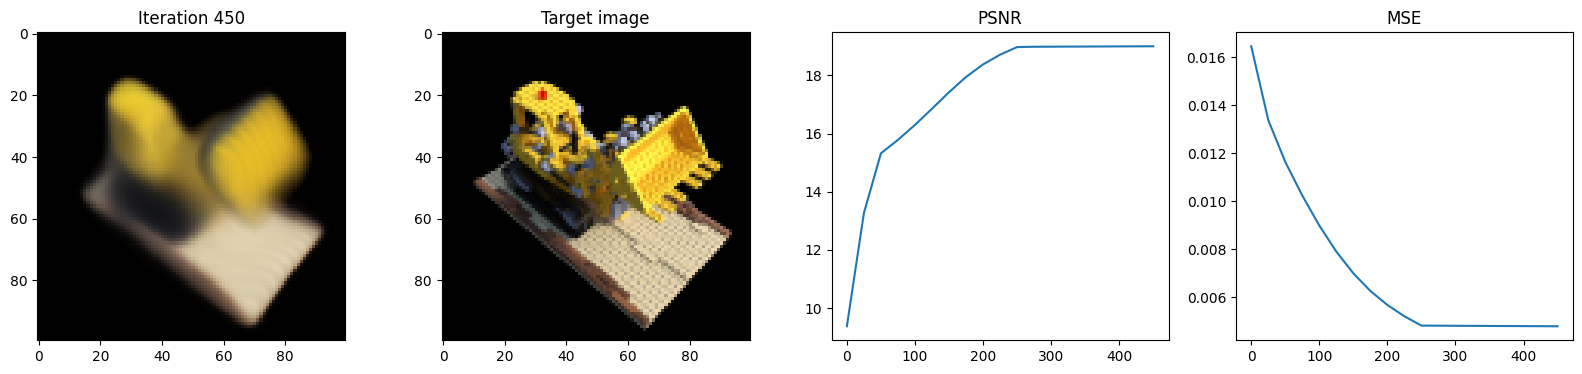

Test image MSE is: 0.004788627848029137
Iteration 475  Loss: 0.0126  PSNR: 19.00  Time: 0.28 secs per iter,  2.67 mins in total


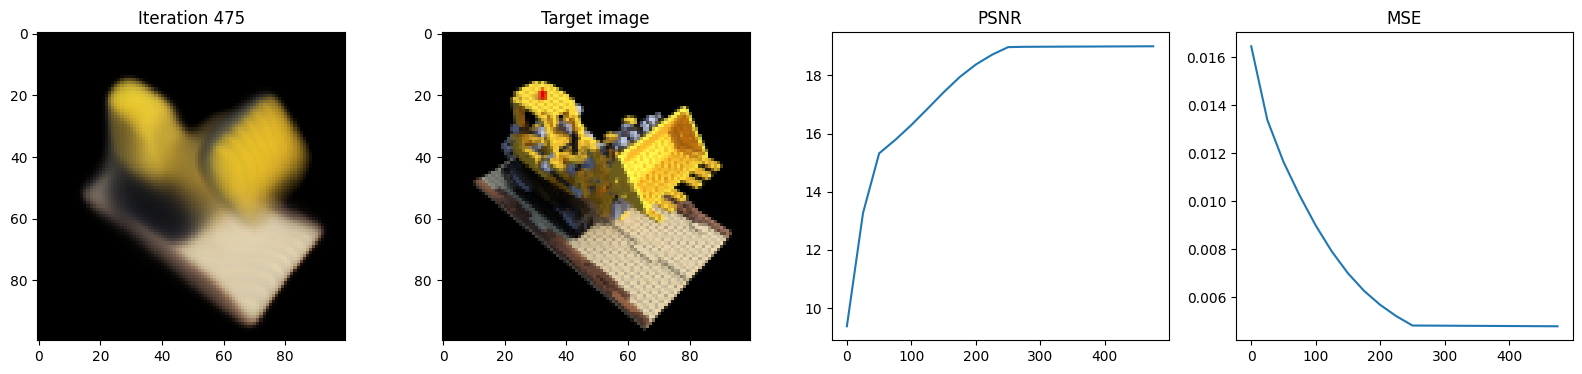

In [20]:
### iterating to see how the error reduces on rotation
mse_list = []
iternums = []
psnrs = []
for i in range(500):
    test_input = copy.deepcopy(test_pose_w_R_c_perturb)
    test_input.requires_grad_()
    # Run one iteration of NeRF and get the rendered RGB image.

    rec_image = one_forward_pass(height, width, intrinsics, test_input.to(device), test_pose_w_T_c.to(device), near, far, samples, model, num_x_frequencies, num_d_frequencies)
    loss = criterion(rec_image, test_image)
    optimizer.zero_grad()
    loss.backward()
    test_pose_w_R_c_perturb = test_pose_w_R_c_perturb - lr_rotation * test_input.grad.detach()
     
    mse = criterion(test_pose_w_R_c_perturb.to('cpu'),test_pose_w_R_c.to('cpu')).detach().item()
    if i%25==0:
        print('Test image MSE is:', mse)
        mse_list.append(mse)

        psnr = 10 * torch.log10((torch.max(test_image)**2)/loss.item())



        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
                "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))
    
        t = time.time()
        psnrs.append(psnr.item())
        iternums.append(i)
    
        plt.figure(figsize=(20, 4))
        plt.subplot(141)
        plt.imshow(rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.subplot(144)
        plt.plot(iternums, mse_list)
        plt.title("MSE")
        plt.show()
    if i%250==0 and i>0 and i<601:
            lr_rotation *= 0.01

    

### Translation only

In [24]:
### test image
test_pose_w_R_c = test_pose[:3,:3]
test_pose_w_T_c = test_pose[:3, 3]
pose_noise = 0.2 # radians
noise = torch.randn_like(test_pose_w_T_c)
test_pose_w_T_c_perturb = test_pose_w_T_c + pose_noise * noise

In [25]:
lr_rotation = 0.1

Test image MSE is: 0.02495850808918476
Iteration 0  Loss: 0.0556  PSNR: 12.55  Time: 5.09 secs per iter,  7.11 mins in total


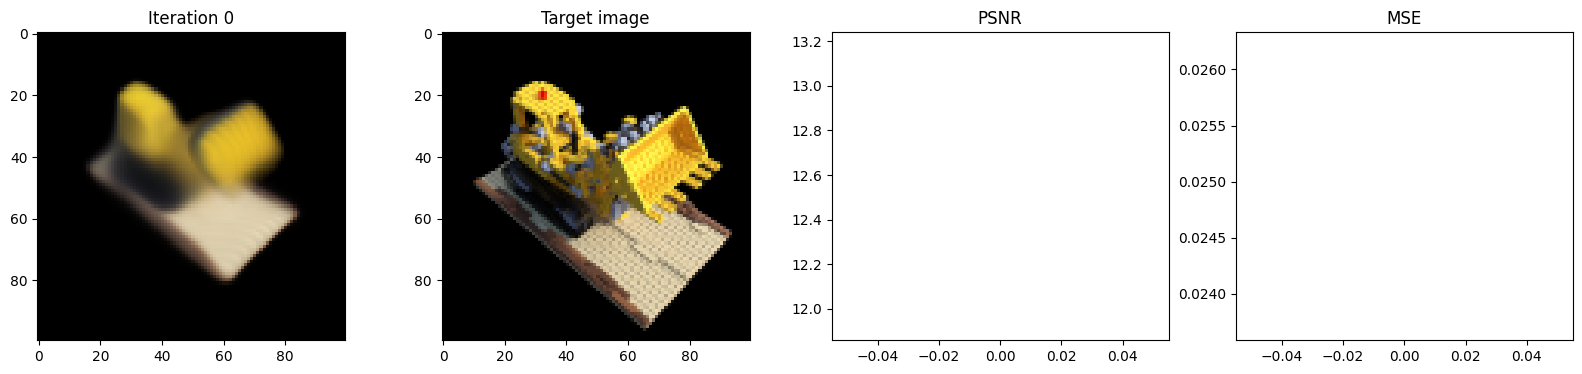

Test image MSE is: 0.000451922562206164
Iteration 25  Loss: 0.0212  PSNR: 16.75  Time: 0.28 secs per iter,  7.22 mins in total


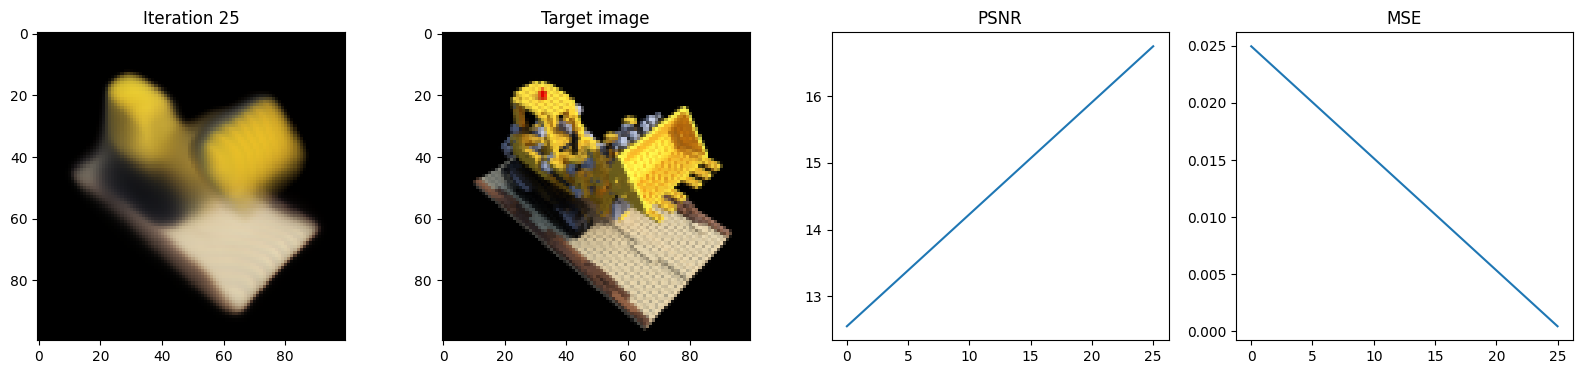

Test image MSE is: 0.0006983781349845231
Iteration 50  Loss: 0.0219  PSNR: 16.60  Time: 0.28 secs per iter,  7.34 mins in total


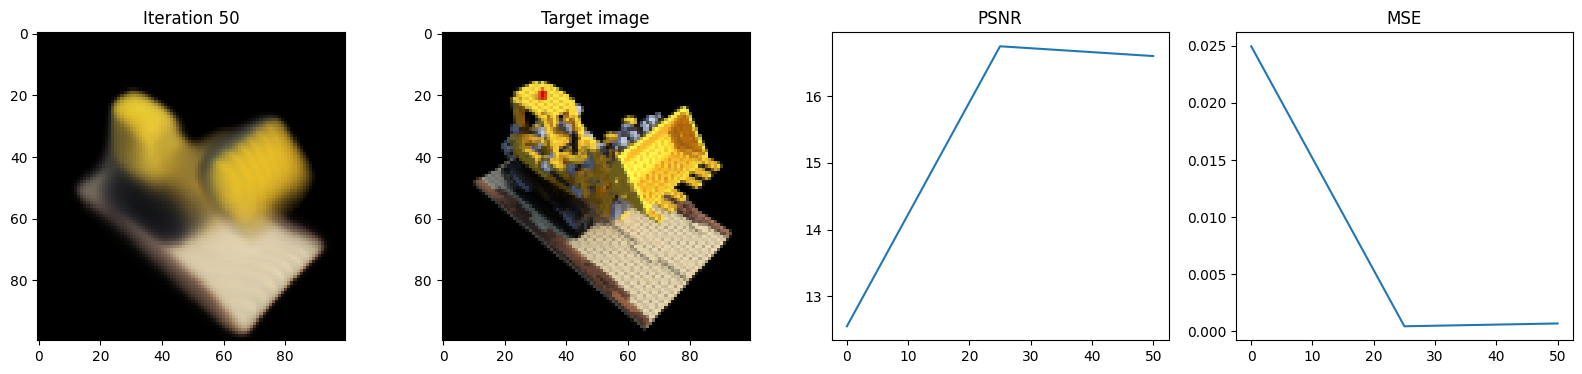

Test image MSE is: 0.00048132744268514216
Iteration 75  Loss: 0.0250  PSNR: 16.02  Time: 0.28 secs per iter,  7.45 mins in total


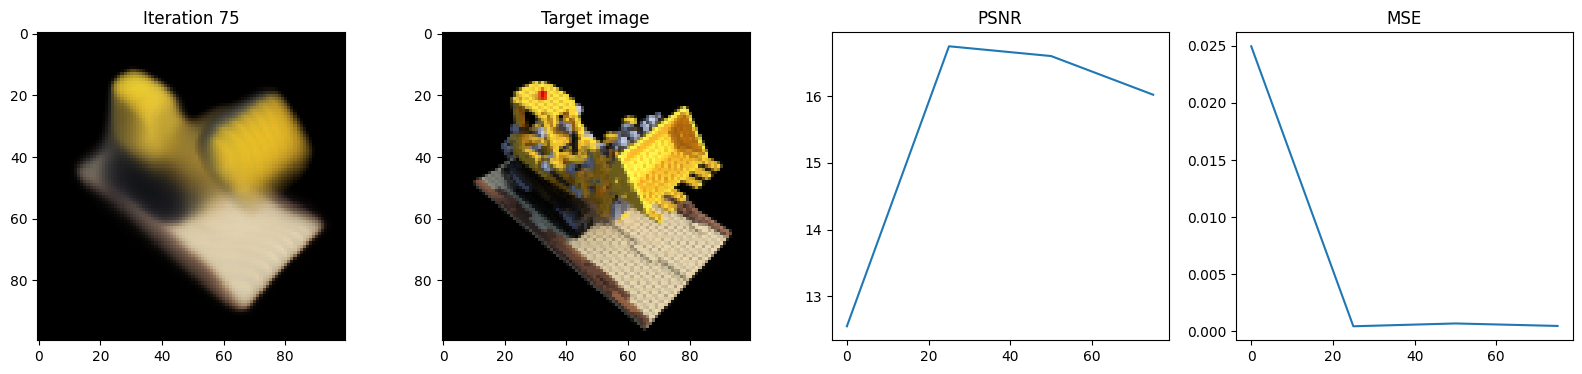

Test image MSE is: 0.0006986887310631573
Iteration 100  Loss: 0.0219  PSNR: 16.60  Time: 0.28 secs per iter,  7.57 mins in total


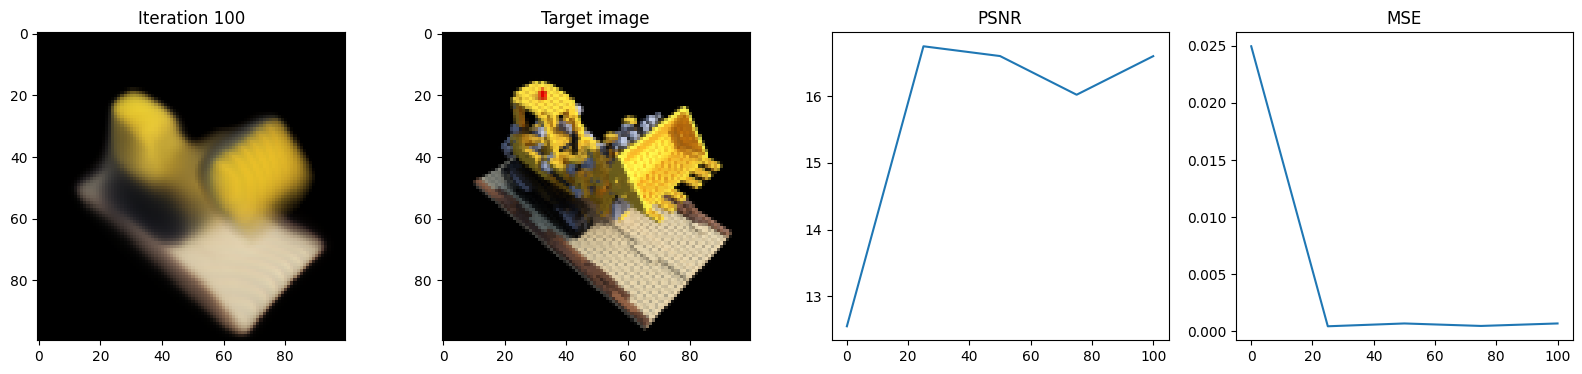

Test image MSE is: 0.00048247387167066336
Iteration 125  Loss: 0.0250  PSNR: 16.02  Time: 0.28 secs per iter,  7.68 mins in total


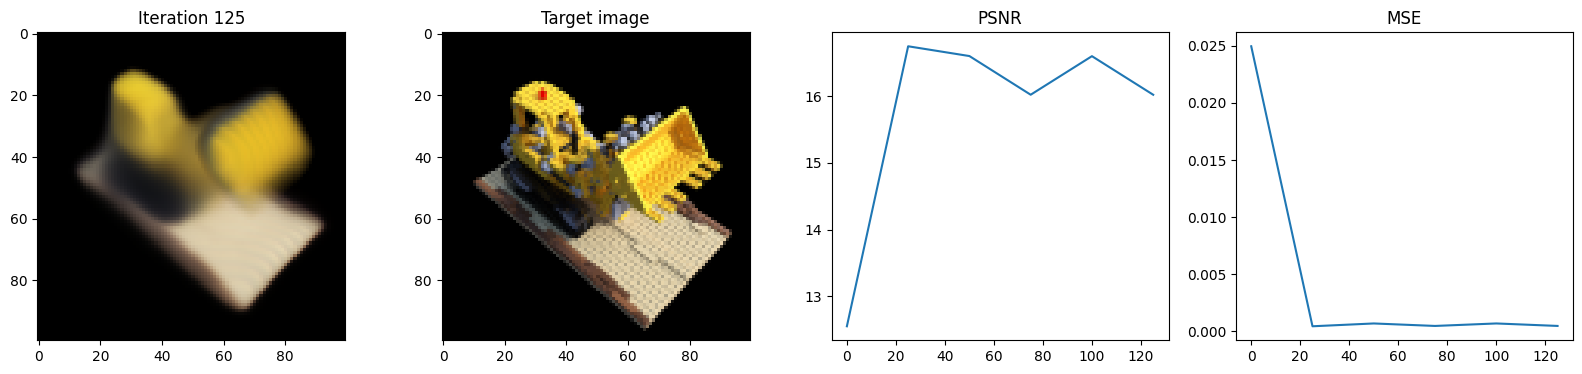

Test image MSE is: 0.0006975529831834137
Iteration 150  Loss: 0.0219  PSNR: 16.60  Time: 0.28 secs per iter,  7.80 mins in total


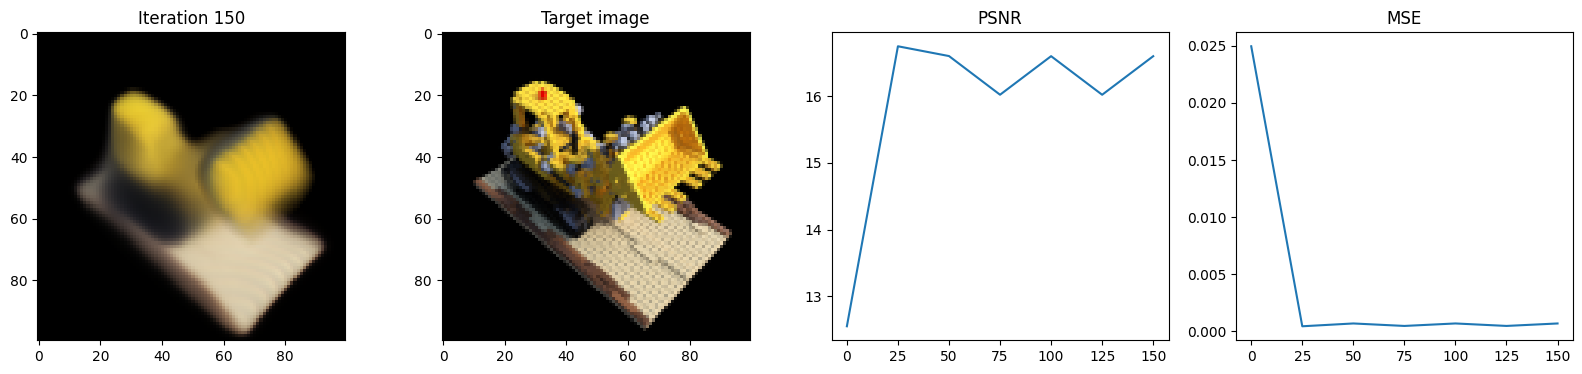

Test image MSE is: 0.0004824624629691243
Iteration 175  Loss: 0.0250  PSNR: 16.02  Time: 0.28 secs per iter,  7.91 mins in total


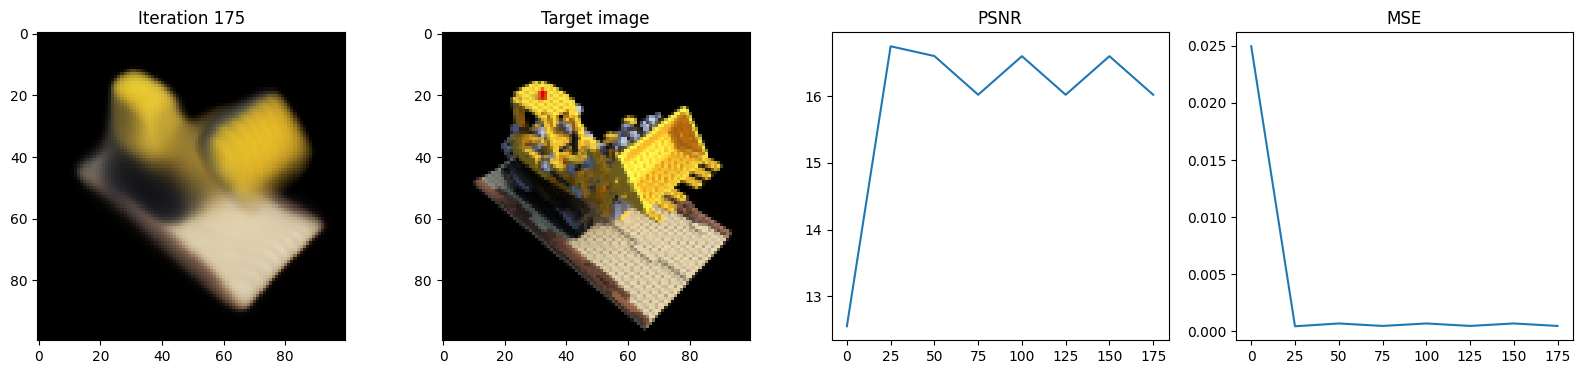

Test image MSE is: 0.0006972766132093966
Iteration 200  Loss: 0.0219  PSNR: 16.60  Time: 0.28 secs per iter,  8.03 mins in total


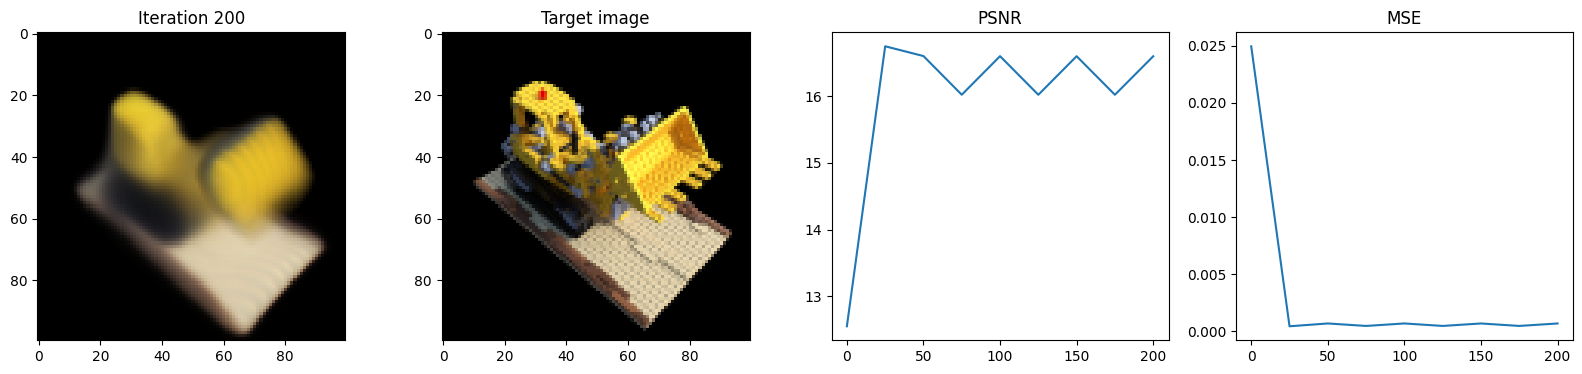

Test image MSE is: 0.0004817130684386939
Iteration 225  Loss: 0.0250  PSNR: 16.02  Time: 0.28 secs per iter,  8.14 mins in total


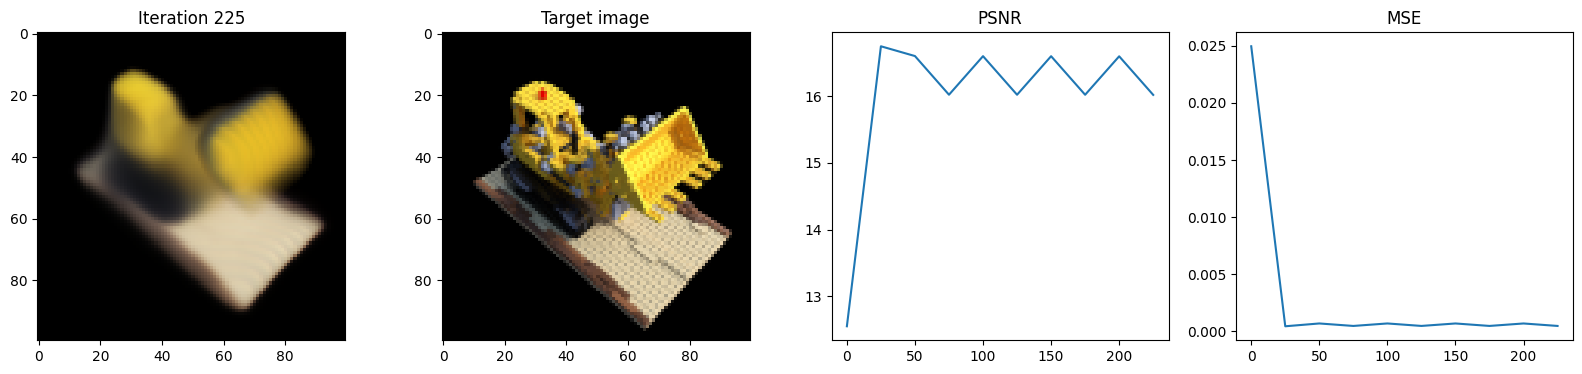

Test image MSE is: 0.0006979493773542345
Iteration 250  Loss: 0.0219  PSNR: 16.60  Time: 0.28 secs per iter,  8.26 mins in total


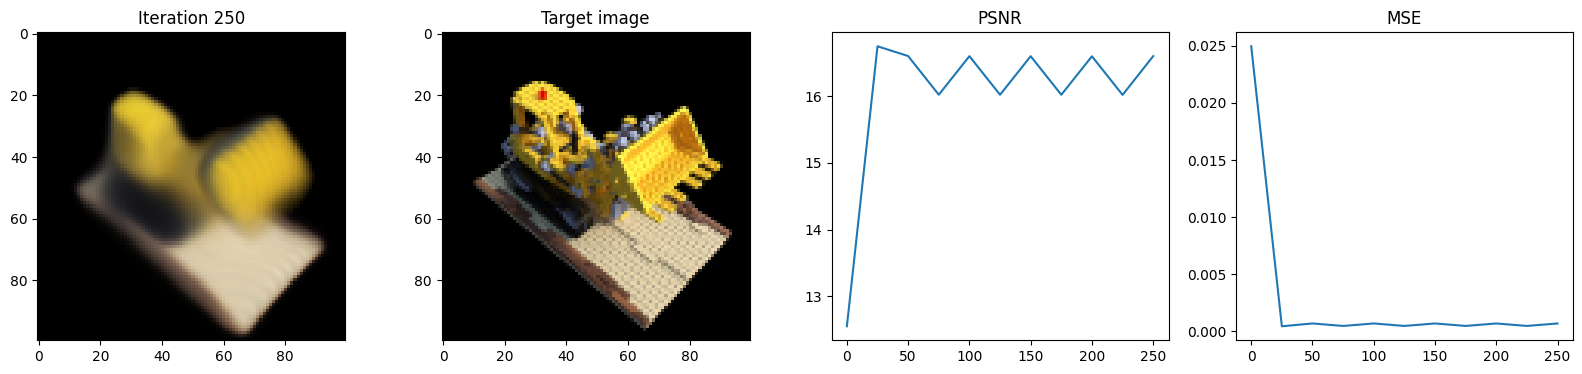

Test image MSE is: 0.0003904045152012259
Iteration 275  Loss: 0.0163  PSNR: 17.88  Time: 0.28 secs per iter,  8.37 mins in total


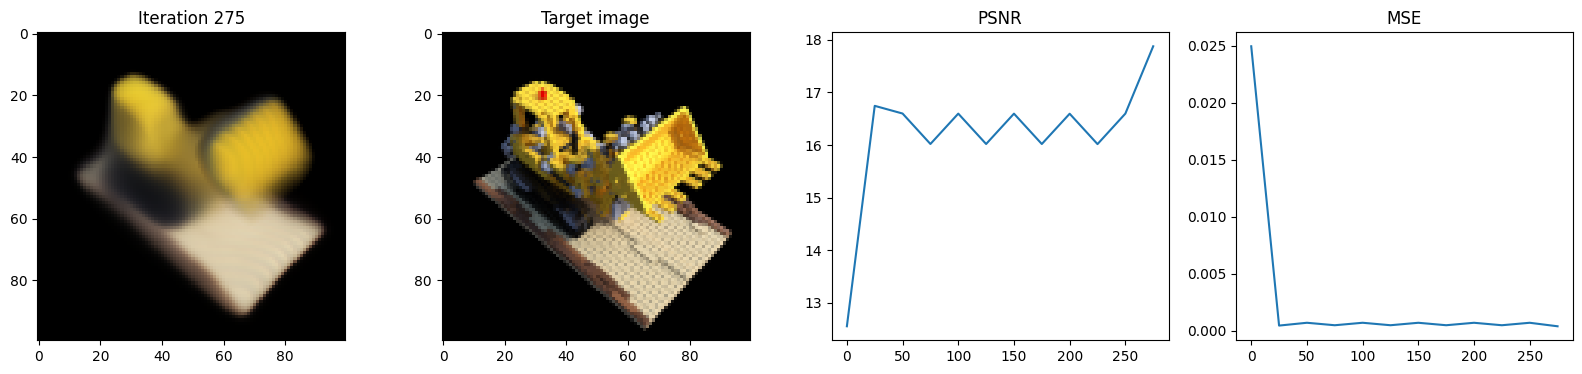

Test image MSE is: 0.0002523714501876384
Iteration 300  Loss: 0.0113  PSNR: 19.46  Time: 0.28 secs per iter,  8.49 mins in total


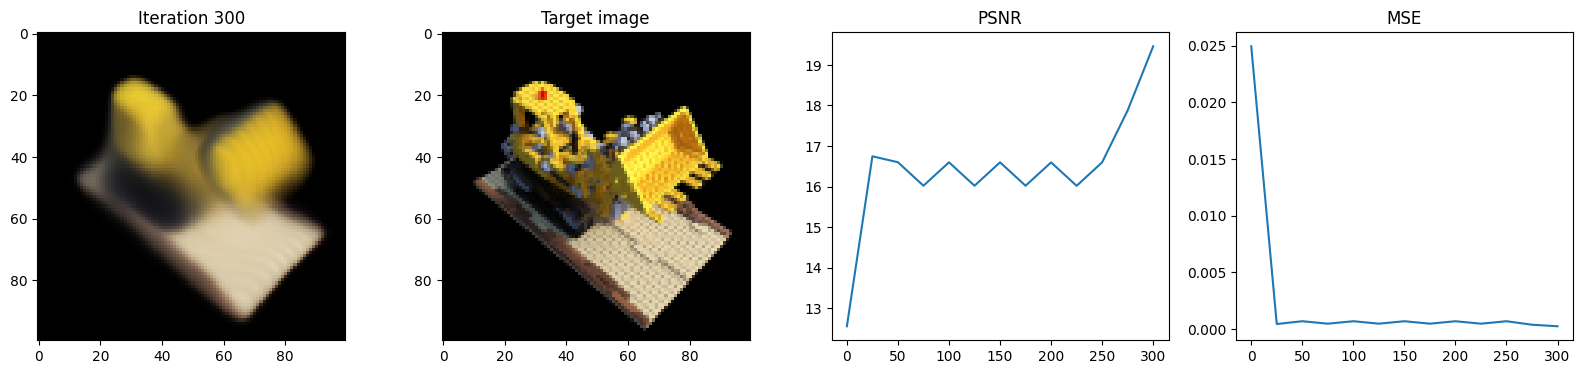

Test image MSE is: 0.00020211166702210903
Iteration 325  Loss: 0.0098  PSNR: 20.09  Time: 0.28 secs per iter,  8.60 mins in total


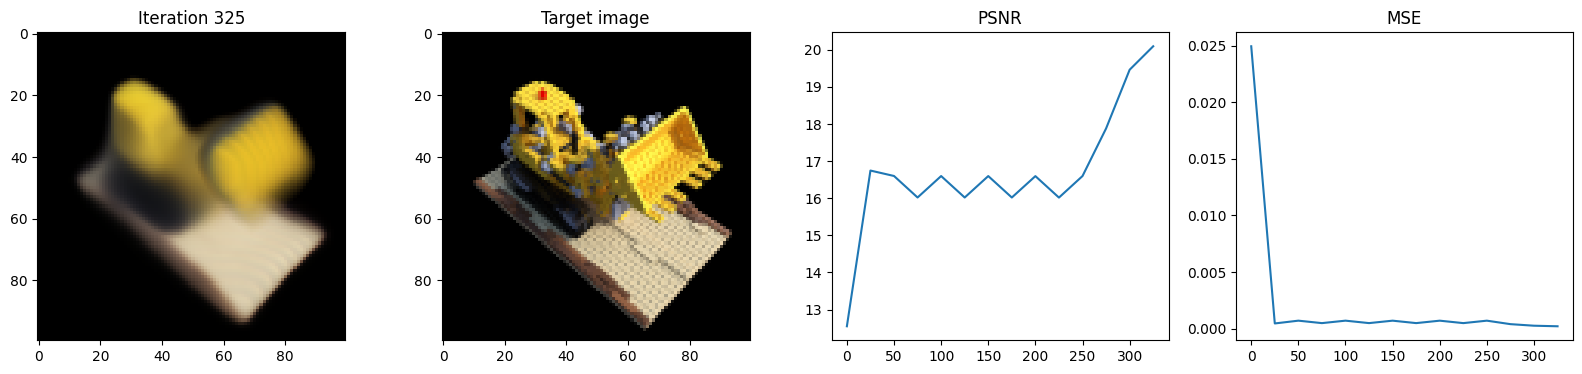

Test image MSE is: 0.00017930024478118867
Iteration 350  Loss: 0.0095  PSNR: 20.23  Time: 0.28 secs per iter,  8.72 mins in total


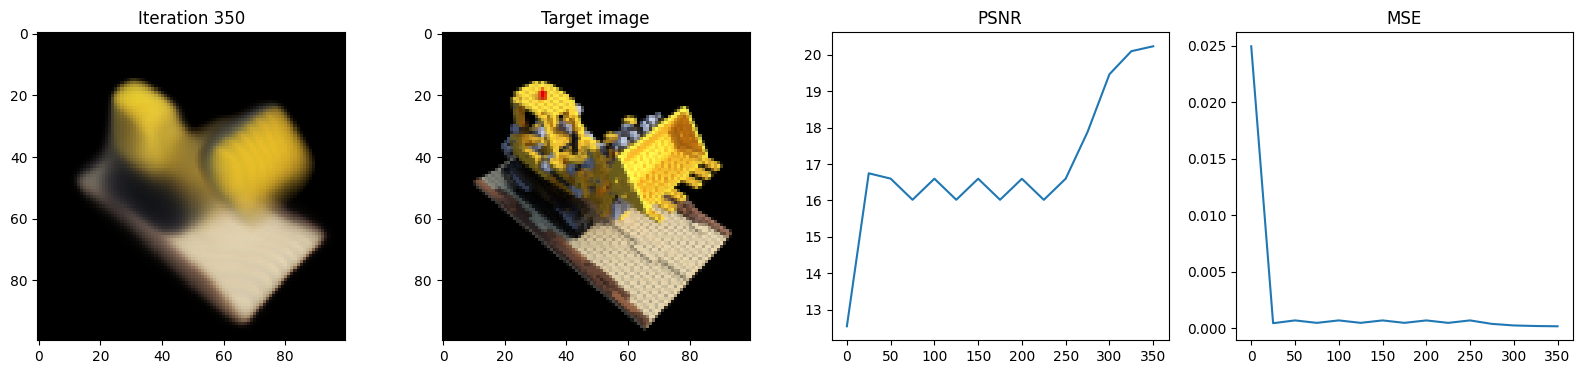

Test image MSE is: 0.0001637429668335244
Iteration 375  Loss: 0.0094  PSNR: 20.26  Time: 0.28 secs per iter,  8.84 mins in total


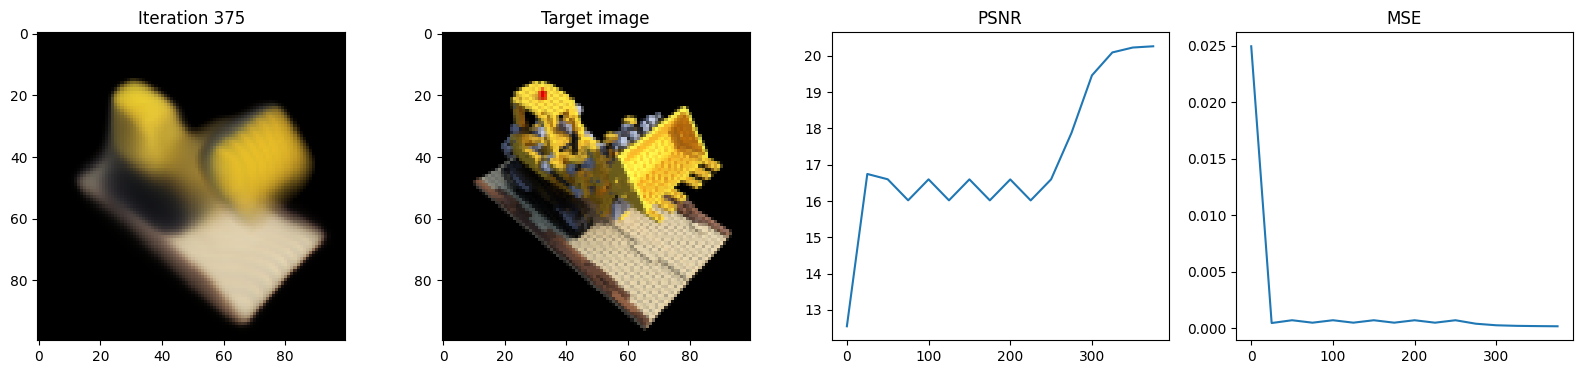

Test image MSE is: 0.00015086409985087812
Iteration 400  Loss: 0.0094  PSNR: 20.28  Time: 0.28 secs per iter,  8.95 mins in total


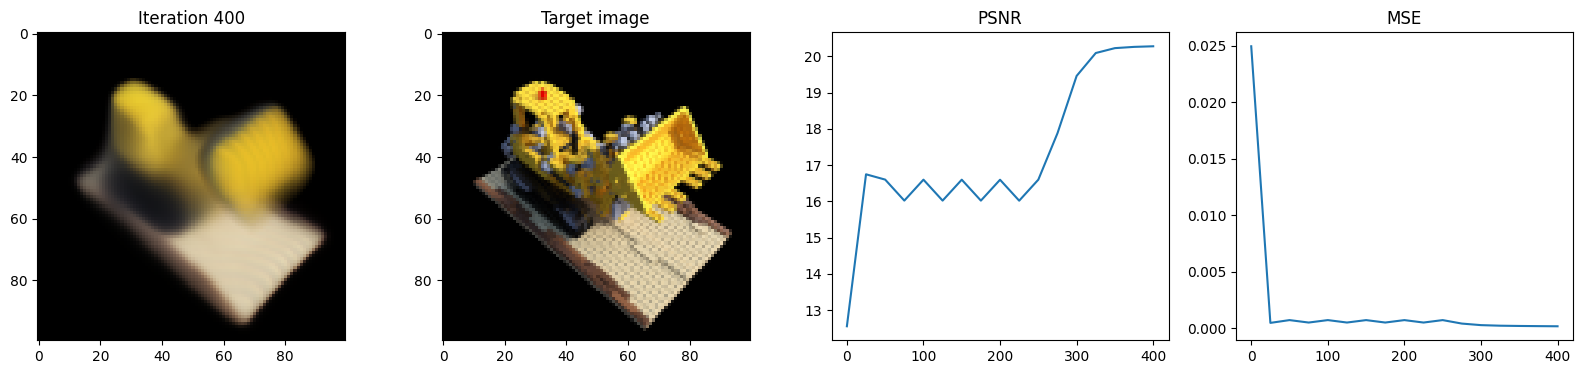

Test image MSE is: 0.00013896181189920753
Iteration 425  Loss: 0.0093  PSNR: 20.29  Time: 0.28 secs per iter,  9.07 mins in total


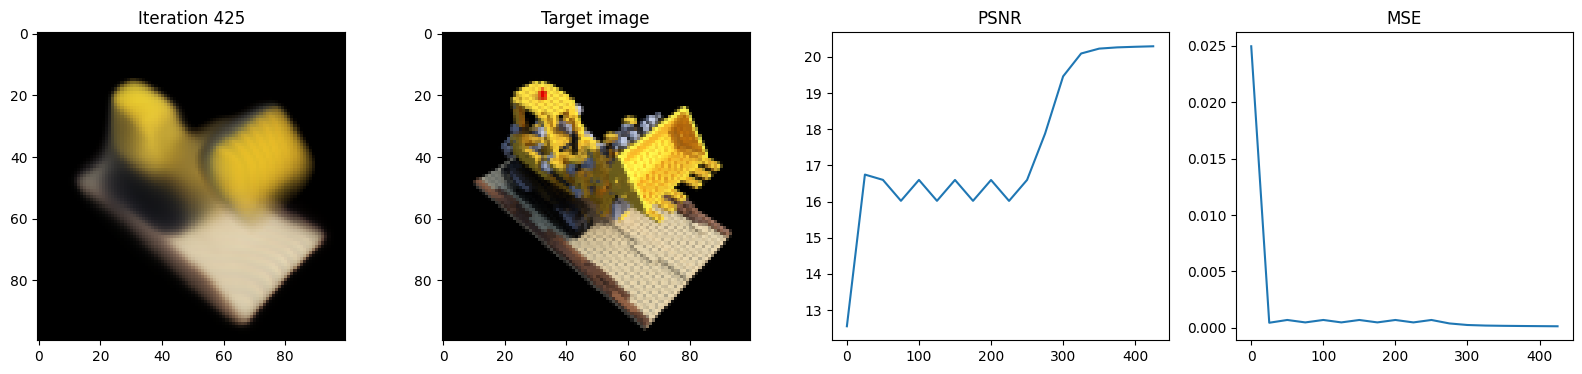

Test image MSE is: 0.00012789183529093862
Iteration 450  Loss: 0.0093  PSNR: 20.31  Time: 0.28 secs per iter,  9.18 mins in total


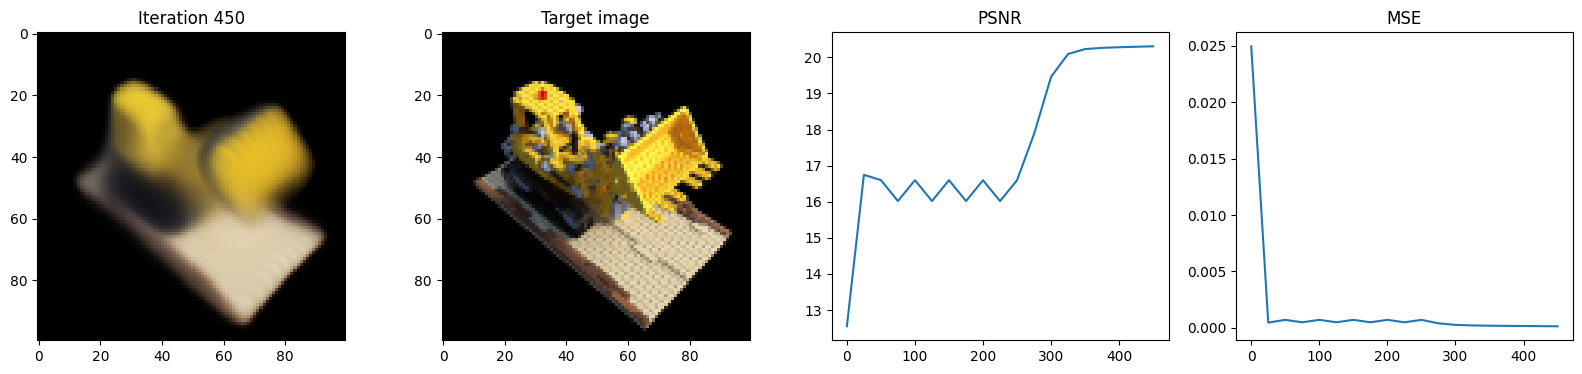

Test image MSE is: 0.00011766453826567158
Iteration 475  Loss: 0.0093  PSNR: 20.32  Time: 0.28 secs per iter,  9.30 mins in total


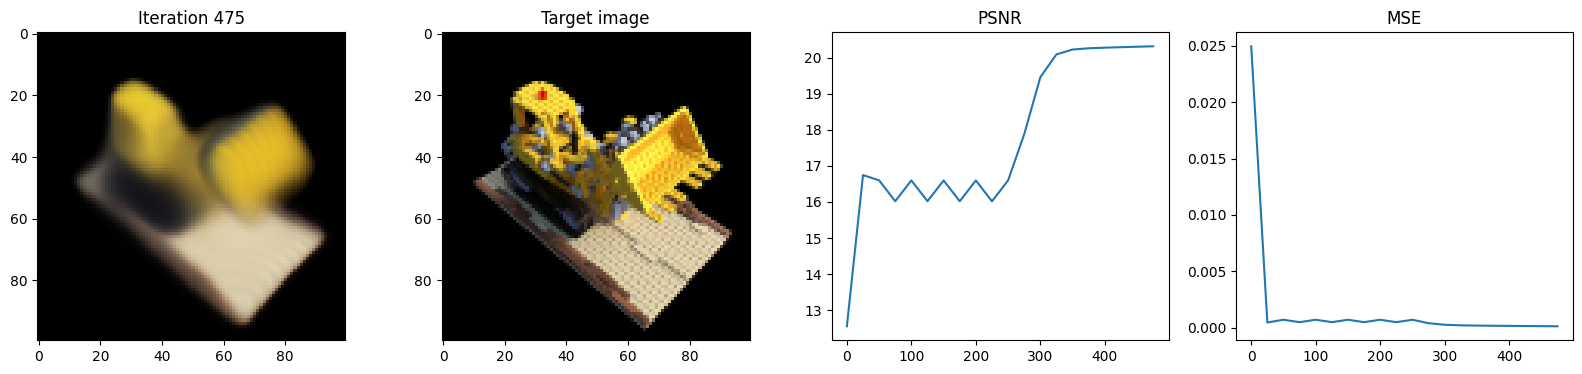

In [26]:
### iterating to see how the error reduces on rotation
mse_list = []
iternums = []
psnrs = []
for i in range(500):
    test_input = copy.deepcopy(test_pose_w_T_c_perturb)
    test_input.requires_grad_()
    # Run one iteration of NeRF and get the rendered RGB image.

    rec_image = one_forward_pass(height, width, intrinsics, test_pose_w_R_c.to(device), test_input.to(device), near, far, samples, model, num_x_frequencies, num_d_frequencies)
    loss = criterion(rec_image, test_image)
    optimizer.zero_grad()
    loss.backward()
    test_pose_w_T_c_perturb = test_pose_w_T_c_perturb - lr_rotation * test_input.grad.detach()
     
    mse = criterion(test_pose_w_T_c_perturb.to('cpu'),test_pose_w_T_c.to('cpu')).detach().item()
    if i%25==0:
        print('Test image MSE is:', mse)
        mse_list.append(mse)

        psnr = 10 * torch.log10((torch.max(test_image)**2)/loss.item())



        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
                "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))
    
        t = time.time()
        psnrs.append(psnr.item())
        iternums.append(i)
        plt.figure(figsize=(20, 4))
        plt.subplot(141)
        plt.imshow(rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.subplot(144)
        plt.plot(iternums, mse_list)
        plt.title("MSE")
        plt.show()
    if i%250==0 and i>0 and i<601:
            lr_rotation *= 0.01

### Both Rotation and Translation

In [27]:
original_test_w_R_c = test_pose[:3,:3]
original_test_w_T_c = test_pose[:3,3]

In [32]:
### test image
test_pose_w_R_c = torch.Tensor(poses[90,:3,:3])
test_pose_w_T_c = torch.Tensor(poses[90,:3, 3])

In [33]:
lr_rotation = 0.01

Test image MSE is: 0.13517336547374725
Iteration 0  Loss: 0.0675  PSNR: 11.71  Time: 12.30 secs per iter,  14.42 mins in total


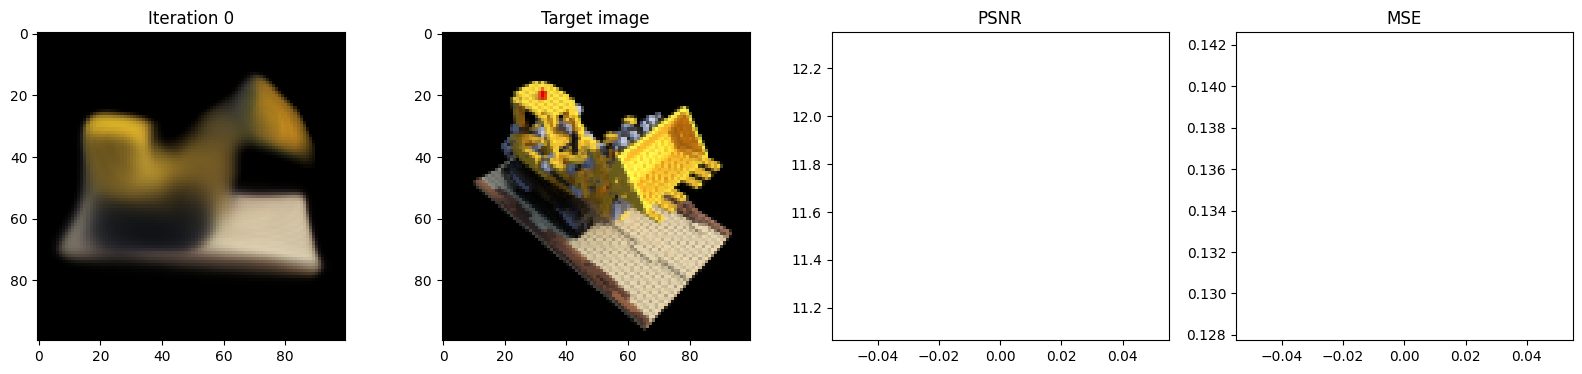

Test image MSE is: 0.1340232938528061
Iteration 25  Loss: 0.0603  PSNR: 12.20  Time: 0.28 secs per iter,  14.54 mins in total


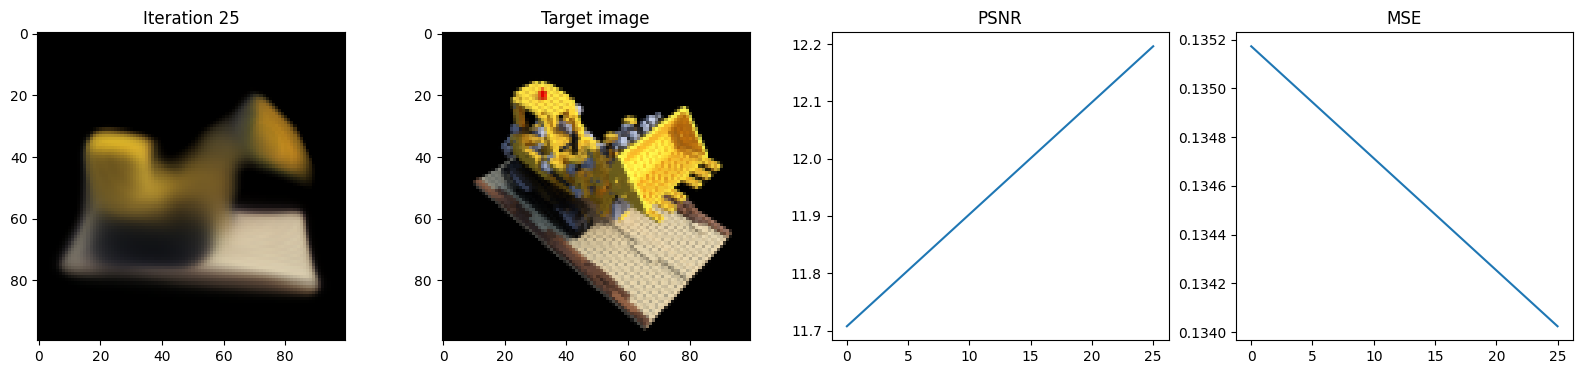

Test image MSE is: 0.13274475932121277
Iteration 50  Loss: 0.0598  PSNR: 12.23  Time: 0.28 secs per iter,  14.66 mins in total


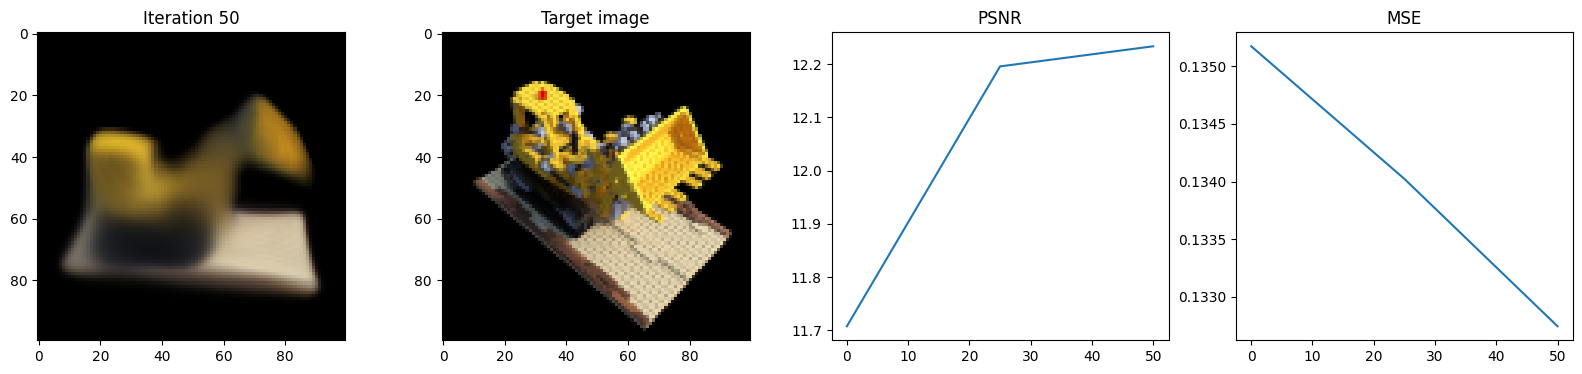

Test image MSE is: 0.13145850598812103
Iteration 75  Loss: 0.0593  PSNR: 12.27  Time: 0.28 secs per iter,  14.77 mins in total


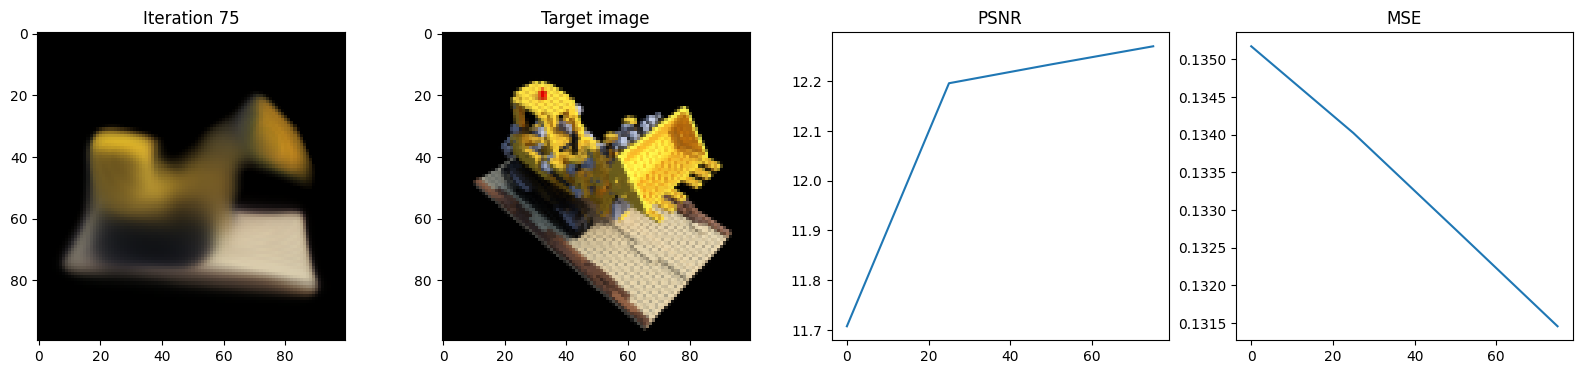

Test image MSE is: 0.1301916241645813
Iteration 100  Loss: 0.0588  PSNR: 12.31  Time: 0.28 secs per iter,  14.89 mins in total


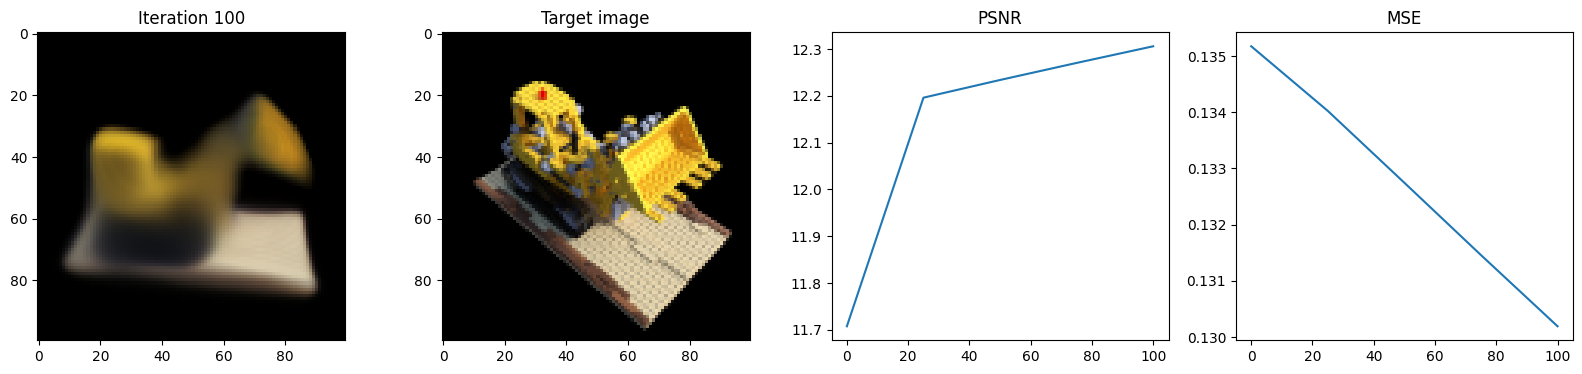

Test image MSE is: 0.12892268598079681
Iteration 125  Loss: 0.0583  PSNR: 12.34  Time: 0.28 secs per iter,  15.01 mins in total


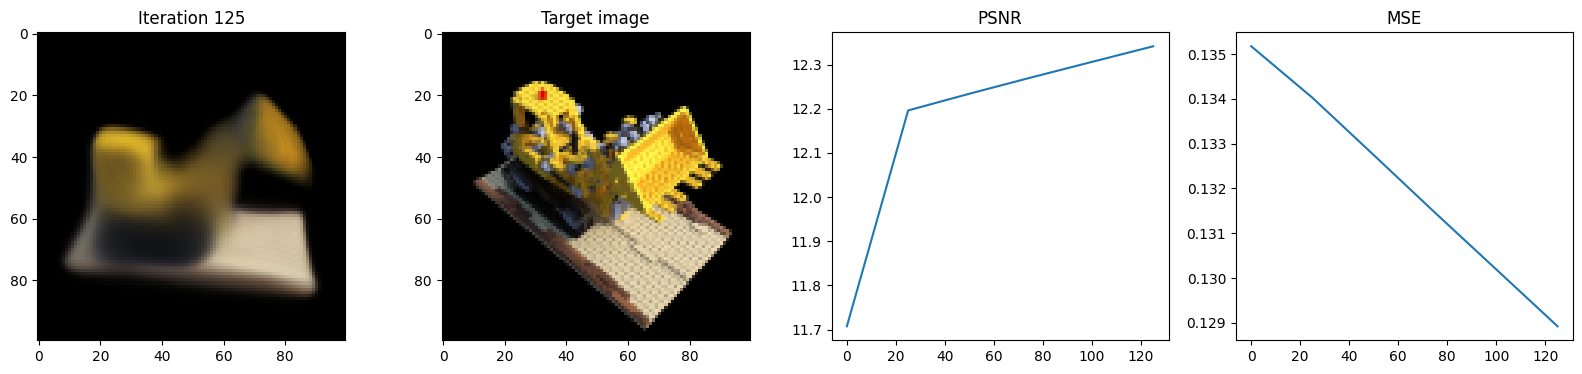

Test image MSE is: 0.12765716016292572
Iteration 150  Loss: 0.0579  PSNR: 12.38  Time: 0.28 secs per iter,  15.12 mins in total


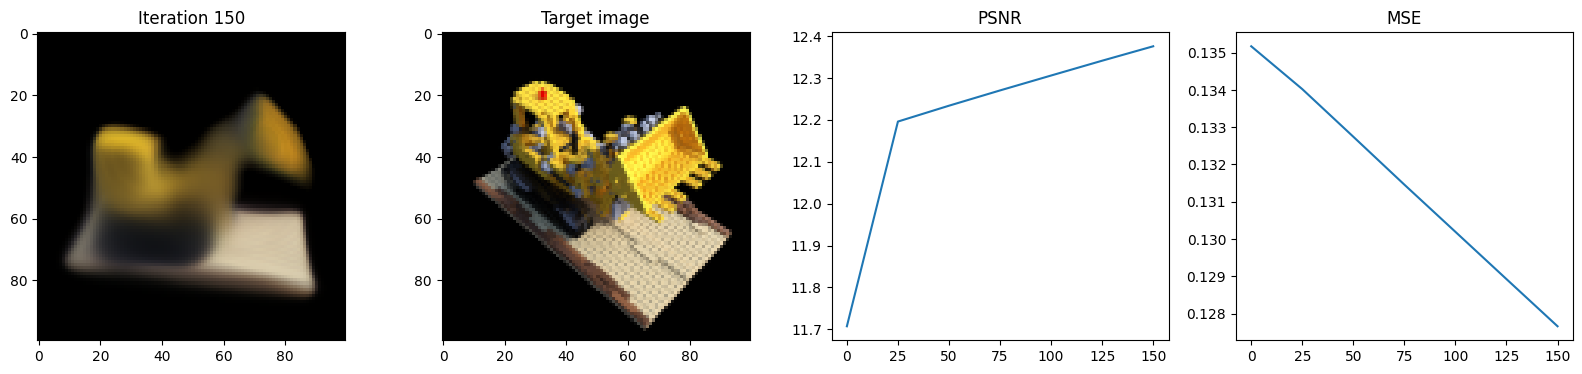

Test image MSE is: 0.12639571726322174
Iteration 175  Loss: 0.0574  PSNR: 12.41  Time: 0.28 secs per iter,  15.24 mins in total


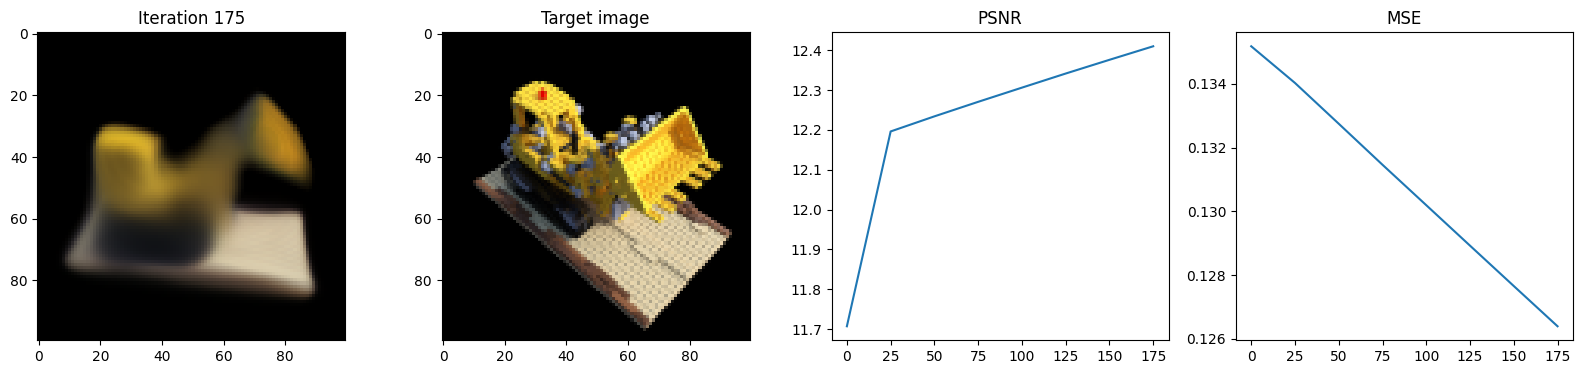

Test image MSE is: 0.12513618171215057
Iteration 200  Loss: 0.0570  PSNR: 12.44  Time: 0.28 secs per iter,  15.35 mins in total


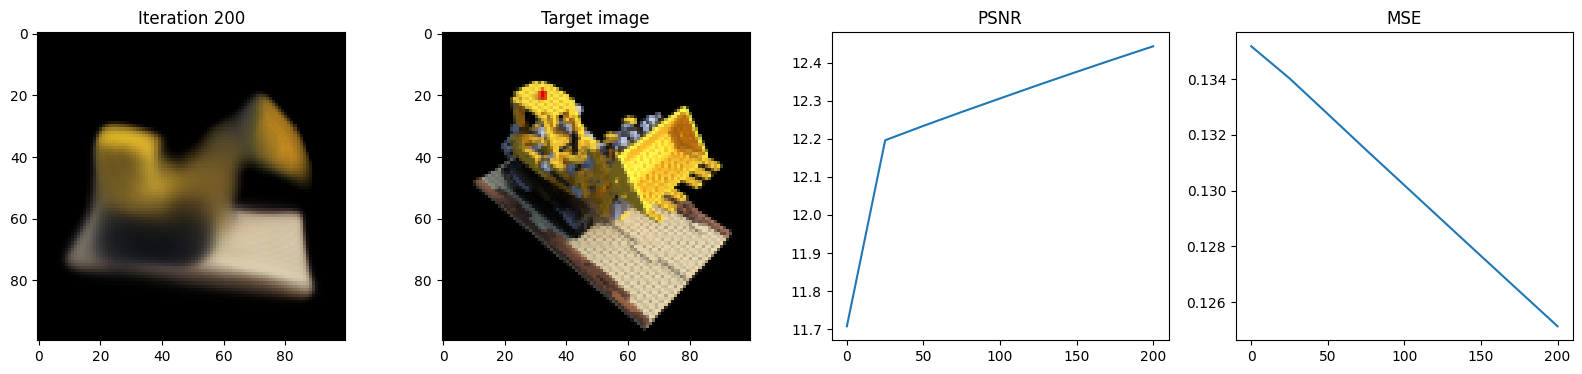

Test image MSE is: 0.12388527393341064
Iteration 225  Loss: 0.0566  PSNR: 12.47  Time: 0.28 secs per iter,  15.47 mins in total


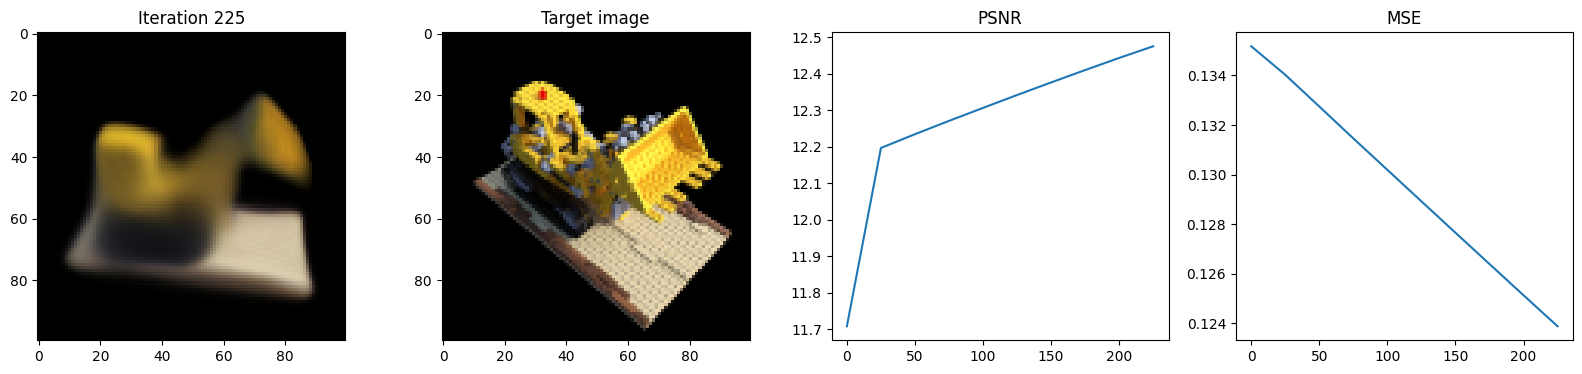

Test image MSE is: 0.12264466285705566
Iteration 250  Loss: 0.0562  PSNR: 12.51  Time: 0.28 secs per iter,  15.59 mins in total


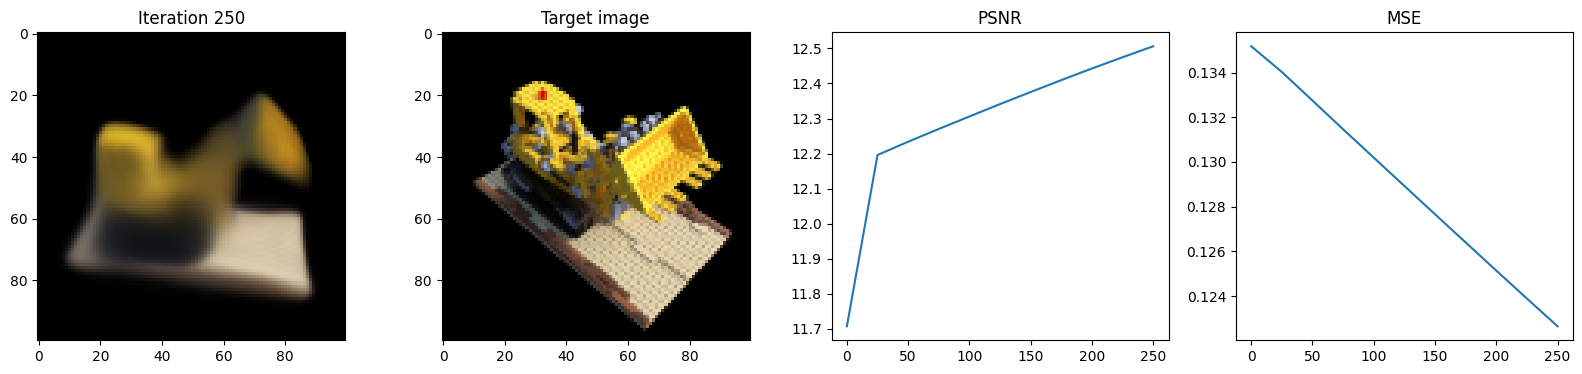

Test image MSE is: 0.12263225764036179
Iteration 275  Loss: 0.0561  PSNR: 12.51  Time: 0.28 secs per iter,  15.70 mins in total


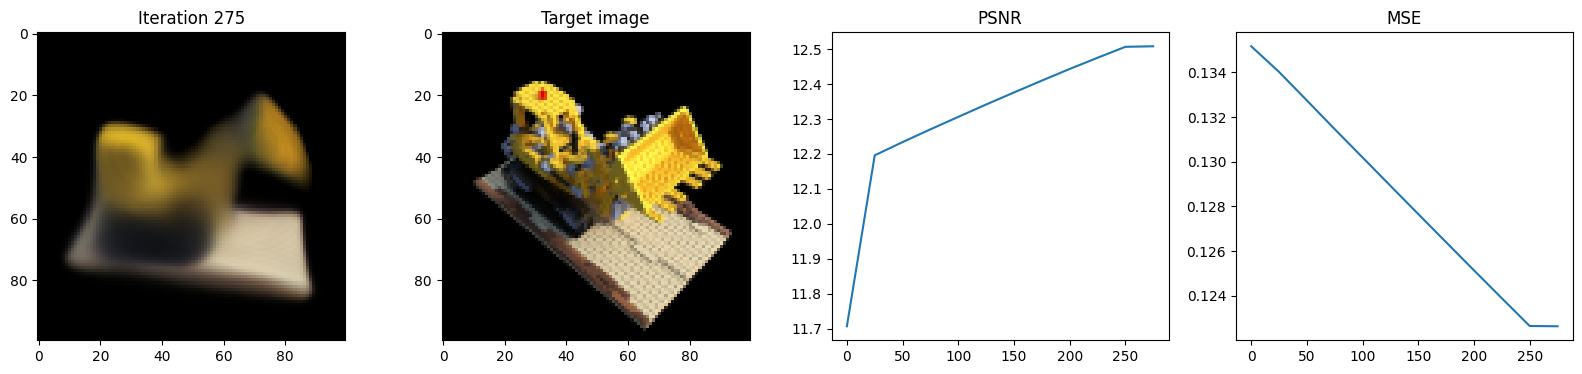

Test image MSE is: 0.12261975556612015
Iteration 300  Loss: 0.0561  PSNR: 12.51  Time: 0.28 secs per iter,  15.82 mins in total


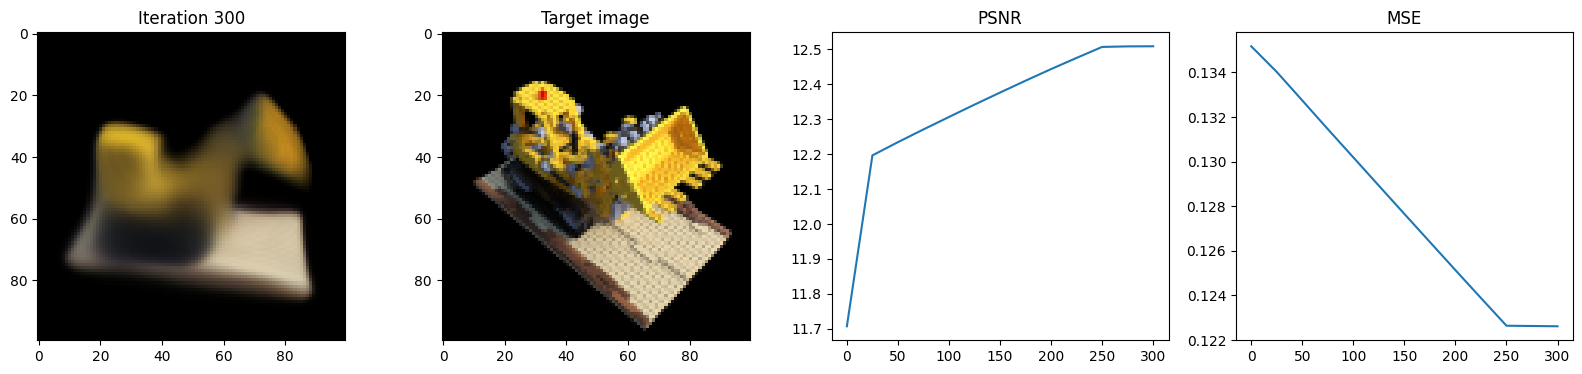

Test image MSE is: 0.12260731309652328
Iteration 325  Loss: 0.0561  PSNR: 12.51  Time: 0.28 secs per iter,  15.94 mins in total


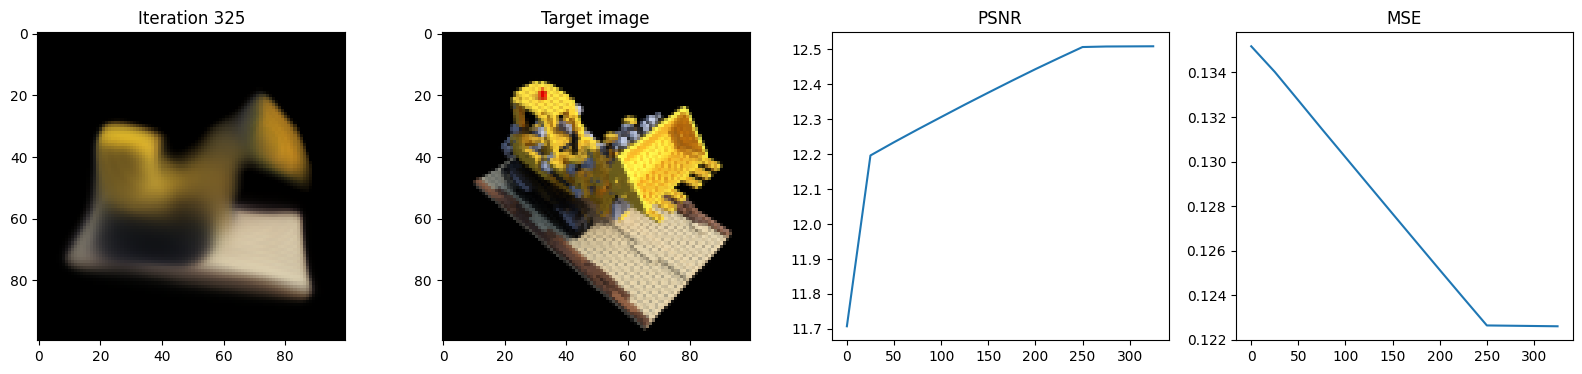

Test image MSE is: 0.12259490042924881
Iteration 350  Loss: 0.0561  PSNR: 12.51  Time: 0.28 secs per iter,  16.05 mins in total


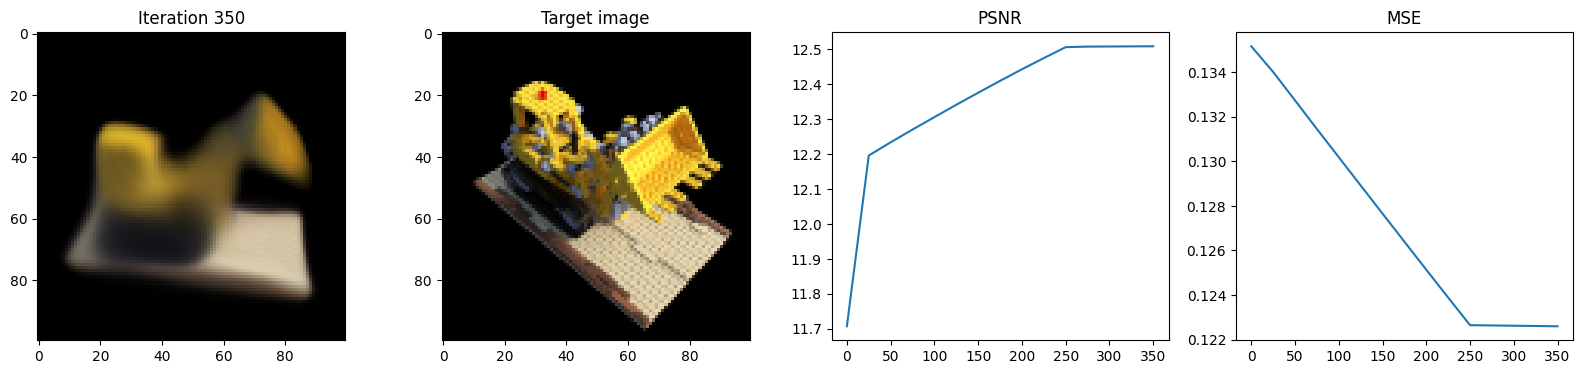

Test image MSE is: 0.12258259207010269
Iteration 375  Loss: 0.0561  PSNR: 12.51  Time: 0.28 secs per iter,  16.17 mins in total


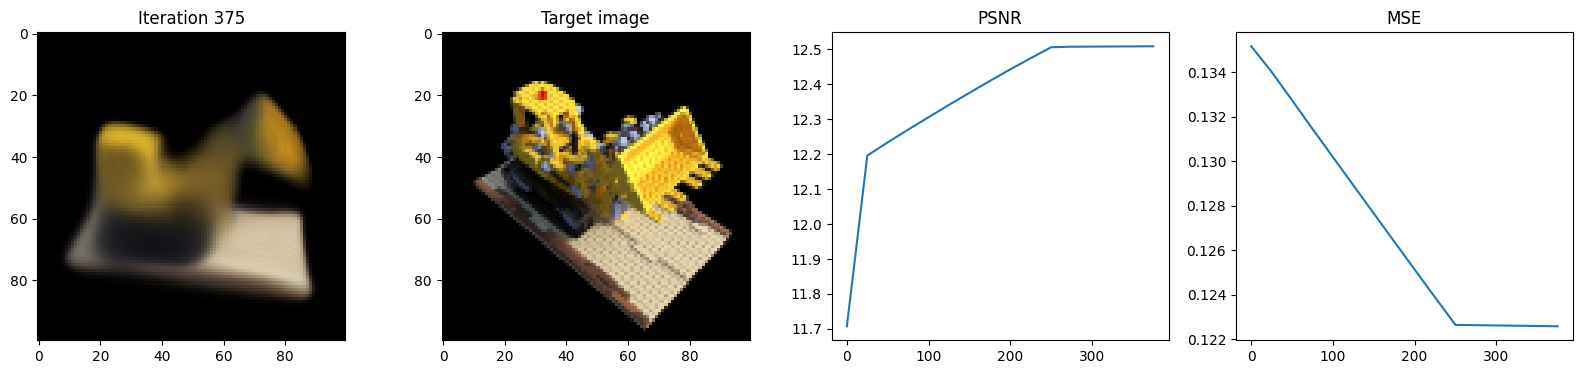

Test image MSE is: 0.12257027626037598
Iteration 400  Loss: 0.0561  PSNR: 12.51  Time: 0.28 secs per iter,  16.29 mins in total


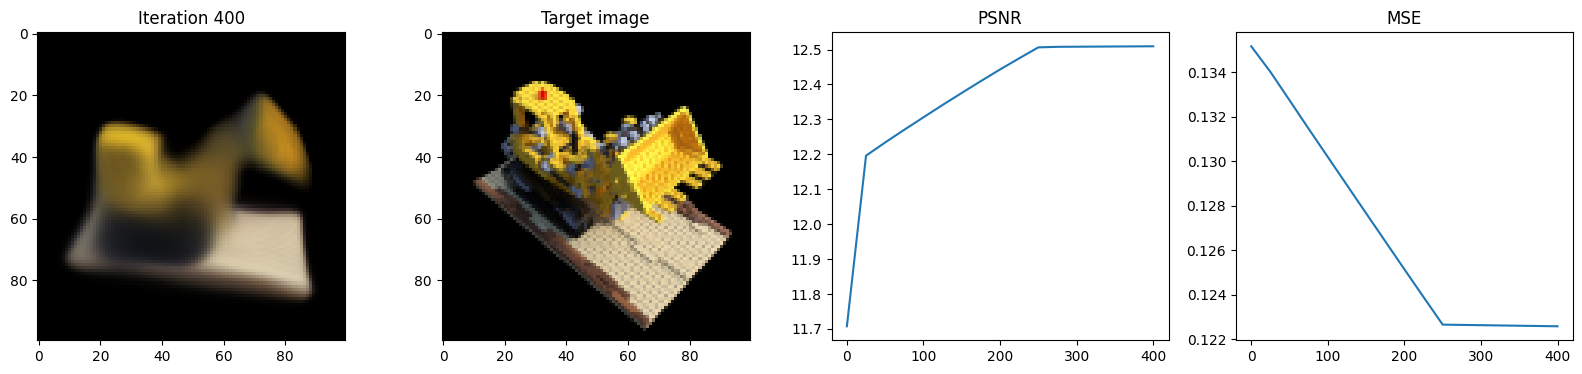

Test image MSE is: 0.12255778908729553
Iteration 425  Loss: 0.0561  PSNR: 12.51  Time: 0.28 secs per iter,  16.40 mins in total


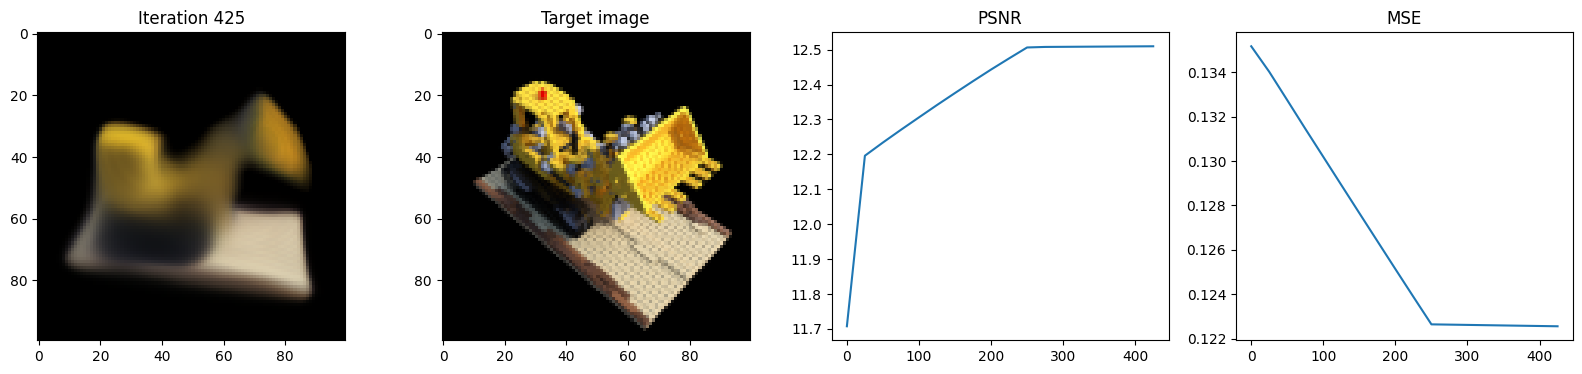

Test image MSE is: 0.12254530191421509
Iteration 450  Loss: 0.0561  PSNR: 12.51  Time: 0.28 secs per iter,  16.52 mins in total


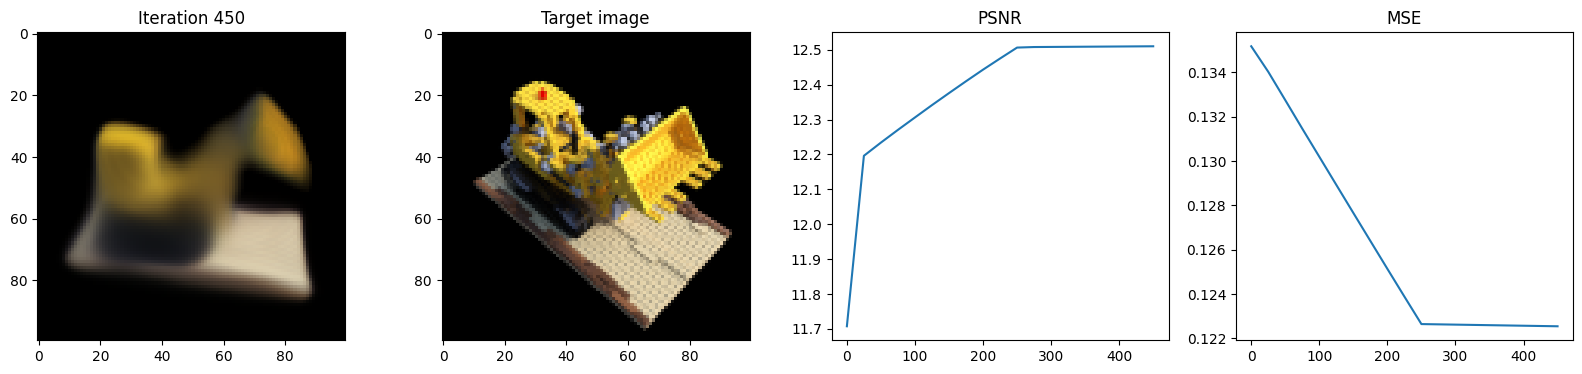

Test image MSE is: 0.12253278493881226
Iteration 475  Loss: 0.0561  PSNR: 12.51  Time: 0.28 secs per iter,  16.63 mins in total


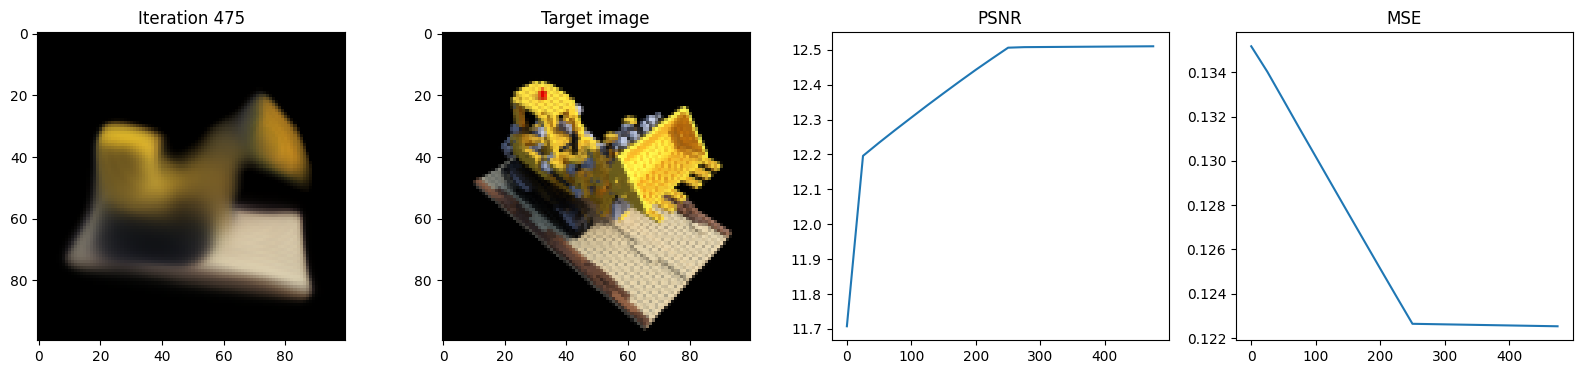

In [40]:
### iterating to see how the error reduces on rotation
mse_list = []
iternums = []
psnrs = []
for i in range(500):
    test_input_w_T_c = copy.deepcopy(test_pose_w_T_c)
    test_input_w_T_c.requires_grad_()
    test_input_w_R_c = copy.deepcopy(test_pose_w_R_c)
    test_input_w_R_c.requires_grad_()
    
    # Run one iteration of NeRF and get the rendered RGB image.

    rec_image = one_forward_pass(height, width, intrinsics, test_input_w_R_c.to(device), test_input_w_T_c.to(device), near, far, samples, model, num_x_frequencies, num_d_frequencies)
    loss = criterion(rec_image, test_image)
    optimizer.zero_grad()
    loss.backward()
    test_pose_w_T_c = test_pose_w_T_c - lr_rotation * test_input_w_T_c.grad.detach()
    test_pose_w_R_c = test_pose_w_R_c - lr_rotation * test_input_w_R_c.grad.detach()

    new_test_pose = torch.concat([test_pose_w_R_c.reshape((3,3)), test_pose_w_T_c.reshape((3,1))], dim=-1)
    mse = criterion(new_test_pose.to('cpu'),test_pose[:3,:].to('cpu')).detach().item()
    if i%25==0:
        print('Test image MSE is:', mse)
        mse_list.append(mse)

        psnr = 10 * torch.log10((torch.max(test_image)**2)/loss.item())



        print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
                "Time: %.2f secs per iter, " % ((time.time() - t) / display), "%.2f mins in total" % ((time.time() - t0)/60))
    
        t = time.time()
        psnrs.append(psnr.item())
        iternums.append(i)
        plt.figure(figsize=(20, 4))
        plt.subplot(141)
        plt.imshow(rec_image.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(142)
        plt.imshow(test_image.detach().cpu().numpy())
        plt.title("Target image")
        plt.subplot(143)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.subplot(144)
        plt.plot(iternums, mse_list)
        plt.title("MSE")
        plt.show()
    if i%250==0 and i>0 and i<601:
            lr_rotation *= 0.01